# Linear Prediction Models

The goal of the linear models is to create a benchmark for the prediction of tRCC gene effect scores for the top essential genes of interest found using models trained on various DepMap CCL datasets. Since the number of tRCC samples is small in this dataset, we will assess how successfully linear models trained generally across all types of DepMap CCLs is in predicting gene effect scores for tRCC.

Firstly, the datasets are preprocessed, cleaned, and standardised for training and analysis. There are four datasets used in the analysis: 
- DepMap Gene Expression - (full dataset, RCC CCLs, ccRCC CCLs)
- DepMap Gene Effects - (full dataset, RCC CCLs, ccRCC CCLs)
- tRCC Gene Expression
- tRCC Gene Effects

There are also two sets of genes of interest:
- Top Common Essential Genes - these are the common essential genes found that are highly negtatively selective for tRCC across all the dependency analyses 
- Top Essential Genes - these are the top 100 essential genes found that are highly negatively selective for tRCC between all the dependency analyses

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
import os
import linear_functions as lf

## Preprocessing Omics and CRISPR Screening Datasets across DepMap CCLs (all CCLs, RCC, ccRCC) and tRCC CCLs

In [2]:
### Script Parameters
#####################

random_state = 1
test_size = 0.2

In [3]:
### DepMap Gene Expression (TPMLogp1)
#####################################
depmap_gene_exp_23Q2 = pd.read_csv("../../datasets/depmap_datasets/23Q2/OmicsExpressionProteinCodingGenesTPMLogp1.csv")
depmap_gene_exp_23Q2.set_index("Unnamed: 0", inplace=True)
depmap_gene_exp_23Q2.index.name = None
depmap_gene_exp_23Q2.sort_index(axis=0, inplace=True)
depmap_gene_exp_23Q2.sort_index(axis=1, inplace=True)
depmap_gene_exp_23Q2.dropna(axis=1, inplace=True)
depmap_gene_exp_23Q2.columns = lf.ExtractGenesNames(depmap_gene_exp_23Q2.columns)

### DepMap Gene Effects (CHRONOS)
#################################
depmap_gene_effect_23Q2 = pd.read_csv('../../datasets/depmap_datasets/23Q2/CRISPRGeneEffect.csv')
depmap_gene_effect_23Q2.set_index("ModelID", inplace=True)
depmap_gene_effect_23Q2.index.name = None
depmap_gene_effect_23Q2.sort_index(axis=0, inplace=True)
depmap_gene_effect_23Q2.sort_index(axis=1, inplace=True)
depmap_gene_effect_23Q2.dropna(axis=1, inplace=True)
depmap_gene_effect_23Q2.columns = lf.ExtractGenesNames(depmap_gene_effect_23Q2.columns)

### TRCC Gene Expression (TPMLogp1)
###################################
DFCI_gene_exp = pd.read_csv("../../datasets/tRCC_cell_lines/raw/RSEM_summary_all_samples_gene_TPM.txt", sep="\t").set_index("gene_id")

STFE1 = pd.read_csv("../../datasets/tRCC_cell_lines/raw/F1.genes.results", sep="\t").set_index("gene_id")["TPM"]
STFE2 = pd.read_csv("../../datasets/tRCC_cell_lines/raw/F2.genes.results", sep="\t").set_index("gene_id")["TPM"]
STFE3 = pd.read_csv("../../datasets/tRCC_cell_lines/raw/F3.genes.results", sep="\t").set_index("gene_id")["TPM"]
STFE_means = pd.concat([STFE1, STFE2, STFE3], axis=1).dropna(axis=1).mean(axis=1)
STFE_means.name = "STFE"

FUUR1_means = DFCI_gene_exp[['B19', 'B20', 'B21']].mean(axis=1)
UOK109_means = DFCI_gene_exp[['B10', 'B11', 'B12']].mean(axis=1)

tRCC_gene_exp = pd.DataFrame({
    'FUUR1': FUUR1_means,
    'UOK109': UOK109_means
}, index=DFCI_gene_exp.index)

tRCC_gene_exp = tRCC_gene_exp.join(STFE_means, how="outer")

tRCC_gene_exp.index.name = None
tRCC_gene_exp.index = tRCC_gene_exp.index.str.split('_').str[-1]
tRCC_gene_exp.sort_index(axis=0, inplace=True)
tRCC_gene_exp.sort_index(axis=1, inplace=True)
tRCC_gene_exp = np.log1p(tRCC_gene_exp)
tRCC_gene_exp = tRCC_gene_exp.groupby(tRCC_gene_exp.index).sum().T
tRCC_gene_exp.to_csv("../../datasets/tRCC_cell_lines/tRCC_gene_exp_TPMLogp1.csv")

### TRCC Gene Effects (CHRONOS)
###############################
DFCI_chronos_dataset = pd.read_csv("../../datasets/tRCC_cell_lines/Chronos/tRCC_chronos_summary_for_BL_ASPS_updated.csv")
DFCI_chronos_CCLs = DFCI_chronos_dataset[["Gene", "PC3", "CAKI2", "CAKI1", "786O", "DU145", "HCT116", "NCIH460", "FUUR1", "STFE", "UOK109"]].T
DFCI_chronos_CCLs.columns = DFCI_chronos_CCLs.iloc[0]
DFCI_chronos_CCLs.columns.name = None
DFCI_chronos_CCLs.drop(DFCI_chronos_CCLs.index[0], inplace=True)
DFCI_chronos_CCLs = DFCI_chronos_CCLs.loc[:, ~(DFCI_chronos_CCLs == 'Unknown').any(axis=0)].apply(pd.to_numeric, errors='coerce').dropna(axis=1)

tRCC_chronos_gene_effects = DFCI_chronos_CCLs.loc[["FUUR1", "STFE", "UOK109"]]
tRCC_chronos_gene_effects.sort_index(axis=0, inplace=True)
tRCC_chronos_gene_effects.sort_index(axis=1, inplace=True)

### Standardise Rows and Columns Between dataframes
###################################################
depmap_gene_exp_23Q2, depmap_gene_effect_23Q2 = lf.Intersect_DF([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2])
tRCC_gene_exp, tRCC_chronos_gene_effects = lf.Intersect_DF([tRCC_gene_exp, tRCC_chronos_gene_effects])
depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, tRCC_gene_exp, tRCC_chronos_gene_effects = lf.Intersect_DF([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, tRCC_gene_exp, tRCC_chronos_gene_effects], match="columns")

print("DepMap dataset row/column check: ", lf.Check_DF_Similarity([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2]))
print("tRCC dataset row/column check: ", lf.Check_DF_Similarity([tRCC_gene_exp, tRCC_chronos_gene_effects]))
print("Check columns across DepMap and tRCC dataframes: ", lf.Check_DF_Similarity([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, tRCC_gene_exp, tRCC_chronos_gene_effects], check="columns"))

### DepMap RCC CCLs
##########################
depmap_RCC_data = pd.read_csv("../../datasets/depmap_datasets/CCLIDs/RCC_depmap_data.csv")
RCC_depmap_gene_exp_23Q2 = depmap_gene_exp_23Q2[depmap_gene_exp_23Q2.index.isin(depmap_RCC_data["depmapId"])]
RCC_depmap_gene_effect_23Q2 = depmap_gene_effect_23Q2[depmap_gene_effect_23Q2.index.isin(depmap_RCC_data["depmapId"])]
 
### DepMap ccRCC CCls
############################
depmap_ccRCC_data = pd.read_csv('../../datasets/depmap_datasets/CCLIDs/ccRCC_depmap_data.csv')
ccRCC_depmap_gene_exp_23Q2 = depmap_gene_exp_23Q2[depmap_gene_exp_23Q2.index.isin(depmap_ccRCC_data["depmapId"])]
ccRCC_depmap_gene_effect_23Q2 = depmap_gene_effect_23Q2[depmap_gene_effect_23Q2.index.isin(depmap_ccRCC_data["depmapId"])]

### Train-Test Datasets
#######################
depmap_X_train, depmap_X_test, depmap_Y_train, depmap_Y_test = train_test_split(depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, test_size=test_size, random_state=random_state)
RCC_X_train, RCC_X_test, RCC_Y_train, RCC_Y_test = train_test_split(RCC_depmap_gene_exp_23Q2, RCC_depmap_gene_effect_23Q2, test_size=test_size, random_state=random_state)
ccRCC_X_train, ccRCC_X_test, ccRCC_Y_train, ccRCC_Y_test = train_test_split(ccRCC_depmap_gene_exp_23Q2, ccRCC_depmap_gene_effect_23Q2, test_size=test_size, random_state=random_state)

### Essential Genes
###################
top_common_essential_genes = pd.read_csv("../../analysis/testGenes/top_common_essential_genes")["gene"]
top100_essential_genes = pd.read_csv("../../analysis/testGenes/top_essential_genes")["Gene"]

DepMap dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
tRCC dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
Check columns across DepMap and tRCC dataframes:  {'all_match': True, 'column_differences': [[], [], [], []]}


## Linear Model Predictions on DepMap CCLs

### Linear Models across full DepMap CCLs Training/Testing subsets

In [4]:
depmap_top_100_essential_gene_linearity = lf.GeneLinearity(depmap_X_train, depmap_Y_train, top100_essential_genes)

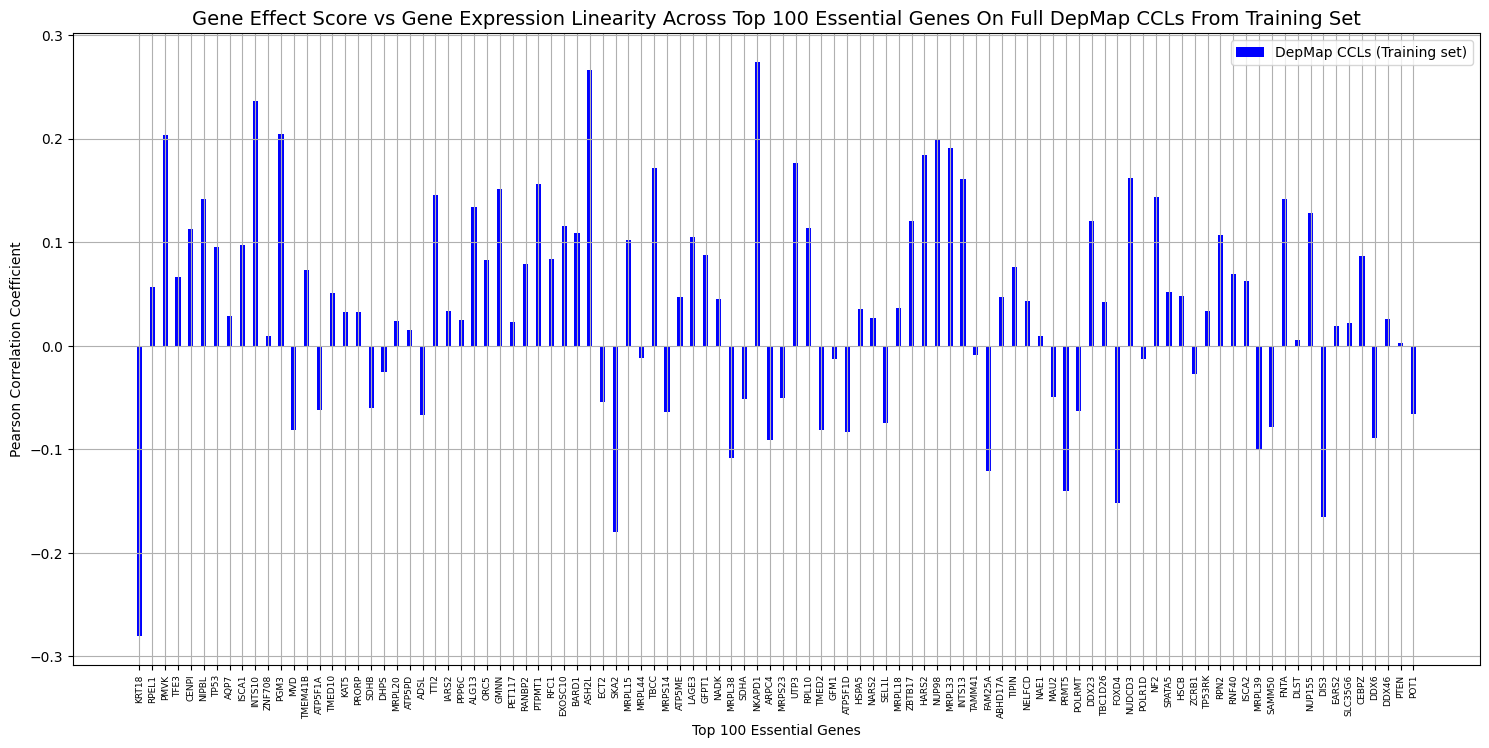

Mean absolute Pearson Correlation Coefficients across top 100 essential genes: 0.08920429254256008


In [8]:
lf.BarChart(depmap_top_100_essential_gene_linearity, 
            {"corr": "blue"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Pearson Correlation Coefficient"], 
            main_title="Gene Effect Score vs Gene Expression Linearity Across Top 100 Essential Genes On Full DepMap CCLs From Training Set",
            legend_titles={"corr": "DepMap CCLs (Training set)"})

print("Mean absolute Pearson Correlation Coefficients across top 100 essential genes: {0}".format(abs(depmap_top_100_essential_gene_linearity["corr"]).mean()))

In [7]:
depmap_top100_essential_gene_models = lf.ComputeGeneLinearModels(depmap_X_train, depmap_Y_train, top100_essential_genes)
depmap_top100_essential_gene_preds, depmap_top100_essential_gene_RMSE = lf.ComputeGenePredictions(depmap_X_test, depmap_Y_test, depmap_top100_essential_gene_models)

In [13]:
RCC_Y_train

A1BG      A1CF       A2M     A2ML1   A3GALT2    A4GALT  \
ACH-000792 -0.039798 -0.041962  0.145072  0.073757 -0.113995  0.008888   
ACH-000907 -0.147761 -0.024956  0.019959  0.167371 -0.143137  0.011335   
ACH-000262 -0.211962  0.102939  0.105905  0.106259 -0.130436  0.099388   
ACH-000234  0.133576 -0.038739 -0.044765  0.142624 -0.162937 -0.185347   
ACH-001163 -0.080792 -0.042643 -0.029733  0.190304 -0.131561 -0.006949   
ACH-000313 -0.113832 -0.101404  0.128648  0.124386 -0.177495 -0.053775   
ACH-000495 -0.142019 -0.112633 -0.023152  0.051131 -0.317712 -0.116598   
ACH-000317 -0.021228 -0.207098  0.068600  0.015759 -0.301172  0.024789   
ACH-001398  0.065959  0.076653 -0.165281  0.135384 -0.362379  0.053965   
ACH-000189  0.072996  0.090618 -0.068657  0.210611  0.152060  0.080668   
ACH-000649 -0.177596 -0.010085  0.003248  0.174043 -0.100769  0.097012   
ACH-000159 -0.094712 -0.137591  0.078154  0.005829 -0.007497 -0.014295   
ACH-000600  0.013187 -0.029312  0.099242  0.044727 -0.213329 -0.099466   
ACH-001688 -0.030382  0.032538 -0.155183  0.186002 -0.291488 -0.301615   
ACH-001687 -0.223345 -0.099523  0.200635  0.286595 -0.130896  0.081597   
ACH-000385  0.074629 -0.212522  0.043524  0.099997 -0.221686  0.044740   
ACH-000375 -0.306213 -0.164945 -0.156490  0.010677  0.005693  0.003492   
ACH-000459  0.185075  0.061845 -0.055029  0.065483 -0.436653 -0.079321   
ACH-000433 -0.192426  0.027420  0.164015  0.142623 -0.148679  0.108587   
ACH-000272 -0.040996 -0.085965  0.037628  0.116145 -0.204229 -0.032905   

               A4GNT      AAAS      AACS     AADAC  ...    ZWILCH     ZWINT  \
ACH-000792  0.079557 -0.104543 -0.007992  0.200958  ... -0.107959 -0.408496   
ACH-000907 -0.047750 -0.281562 -0.046867  0.072852  ... -0.203165 -0.409548   
ACH-000262  0.155385 -0.342191 -0.004001  0.083557  ... -0.340361 -0.691398   
ACH-000234  0.046380 -0.227069 -0.196662  0.146701  ...  0.055215 -0.270229   
ACH-001163  0.041358 -0.537059 -0.002709  0.109117  ... -0.008955 -0.407236   
ACH-000313  0.074751 -0.203273  0.015924  0.057884  ...  0.004683 -0.442883   
ACH-000495  0.132468 -0.575592 -0.127428  0.258432  ... -0.209768 -0.020796   
ACH-000317  0.008364 -0.030318  0.042525  0.091677  ... -0.128879 -0.298970   
ACH-001398  0.068693 -0.638054  0.203742  0.384756  ...  0.045761 -0.769928   
ACH-000189  0.044678 -0.197176  0.009398  0.262064  ... -0.176592 -0.795498   
ACH-000649  0.047771 -0.136448 -0.091555  0.034513  ... -0.260489 -0.429056   
ACH-000159  0.160703 -0.239136 -0.005549  0.158619  ... -0.214795 -0.989132   
ACH-000600  0.088943 -0.067797  0.073356  0.205936  ... -0.275358 -0.572476   
ACH-001688 -0.135048 -0.579316  0.046567  0.232244  ...  0.054140 -0.714741   
ACH-001687  0.011355 -0.200981 -0.101800  0.210451  ... -0.321769 -0.260835   
ACH-000385  0.209196 -0.322960 -0.134398  0.211795  ... -0.093551 -0.230715   
ACH-000375  0.062274 -0.300936 -0.000291  0.215415  ... -0.371630 -0.612019   
ACH-000459 -0.063317  0.087054 -0.127658  0.166037  ...  0.060643 -0.335876   
ACH-000433 -0.100357 -0.325591 -0.139773  0.142295  ... -0.162338 -0.697947   
ACH-000272  0.062697 -0.071290  0.043986  0.099893  ... -0.402469 -0.492076   

                ZXDA      ZXDB      ZXDC    ZYG11A    ZYG11B       ZYX  \
ACH-000792  0.168099  0.223587 -0.069128  0.010337 -0.087661  0.021165   
ACH-000907  0.030940  0.067033 -0.034069 -0.144219 -0.066198 -0.329474   
ACH-000262  0.118290 -0.055141 -0.191830 -0.021908 -0.310319 -0.202366   
ACH-000234 -0.079516  0.027621 -0.073244  0.062877 -0.230145  0.049119   
ACH-001163 -0.039378  0.075877 -0.041358 -0.005405  0.083545 -0.230946   
ACH-000313  0.126030  0.330771 -0.020090 -0.046287 -0.180943 -0.070030   
ACH-000495  0.072230  0.045644  0.019910 -0.140784 -0.818626 -0.007163   
ACH-000317 -0.061941  0.144111 -0.086397 -0.052827 -0.073299 -0.060473   
ACH-001398  0.039418  0.200230 -0.179294  0.126673 -0.470618 -0.050456   
ACH-000189  0.337358  0.035441 -0.178653 -0.149128 -0.467706 

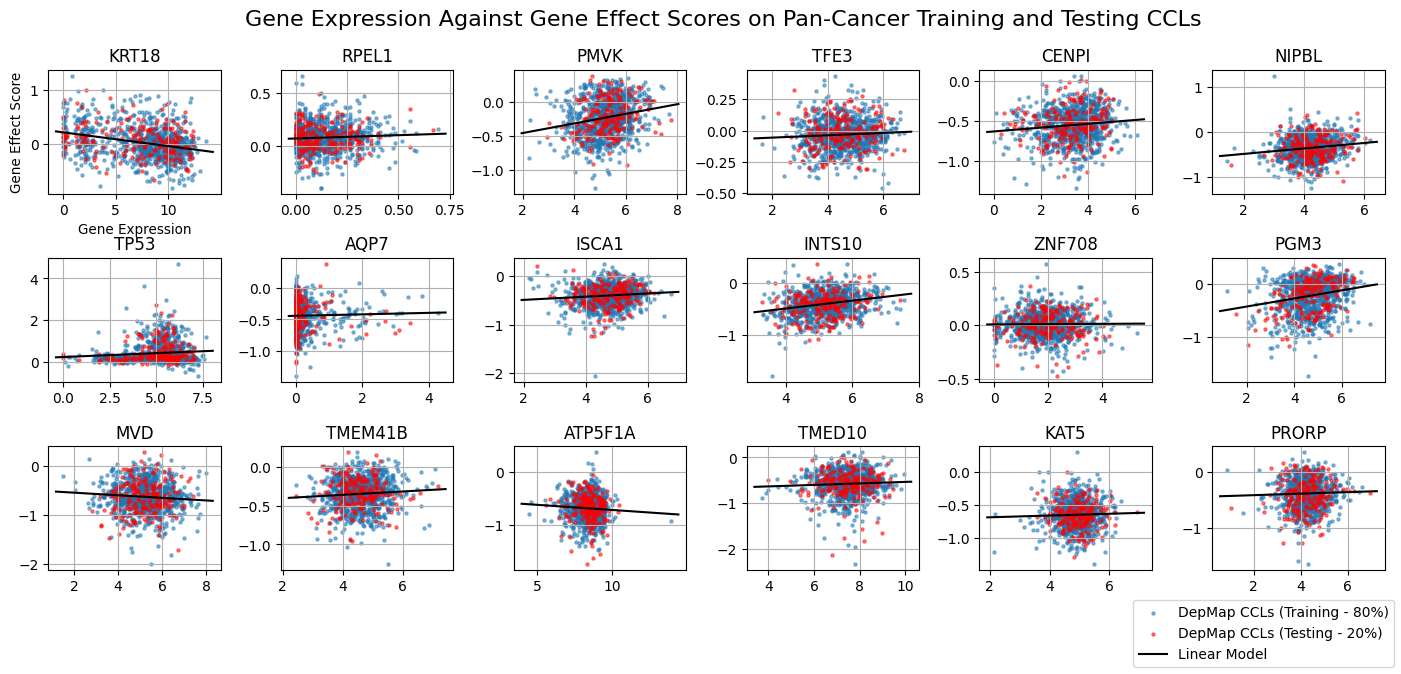

In [7]:
lf.GeneRelMiniPlot(depmap_X_train, depmap_Y_train, top100_essential_genes[:18],
                   rel2_X=depmap_X_test,
                   rel2_Y=depmap_Y_test,
                   models=depmap_top100_essential_gene_models,
                   main_title="Gene Expression Against Gene Effect Scores on Pan-Cancer Training and Testing CCLs",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "DepMap CCLs (Training - 80%)", "rel2": "DepMap CCLs (Testing - 20%)", "model": "Linear Model"},
                   sizeProps=[0.89, 0.15, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

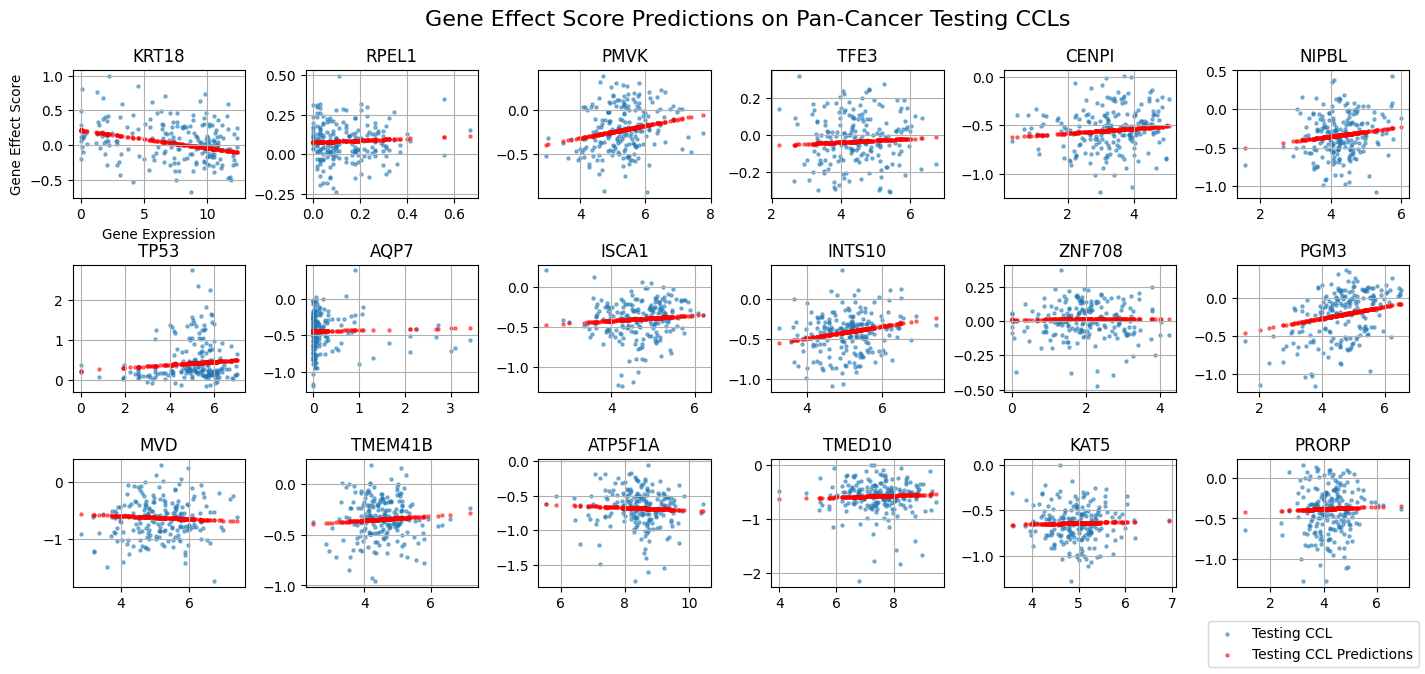

In [8]:
lf.GeneRelMiniPlot(depmap_X_test, depmap_Y_test, top100_essential_genes[:18],
                   rel2_X=depmap_X_test,
                   rel2_Y=depmap_top100_essential_gene_preds,
                   main_title="Gene Effect Score Predictions on Pan-Cancer Testing CCLs",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "Testing CCL", "rel2": "Testing CCL Predictions"},
                   sizeProps=[0.89, 0.125, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

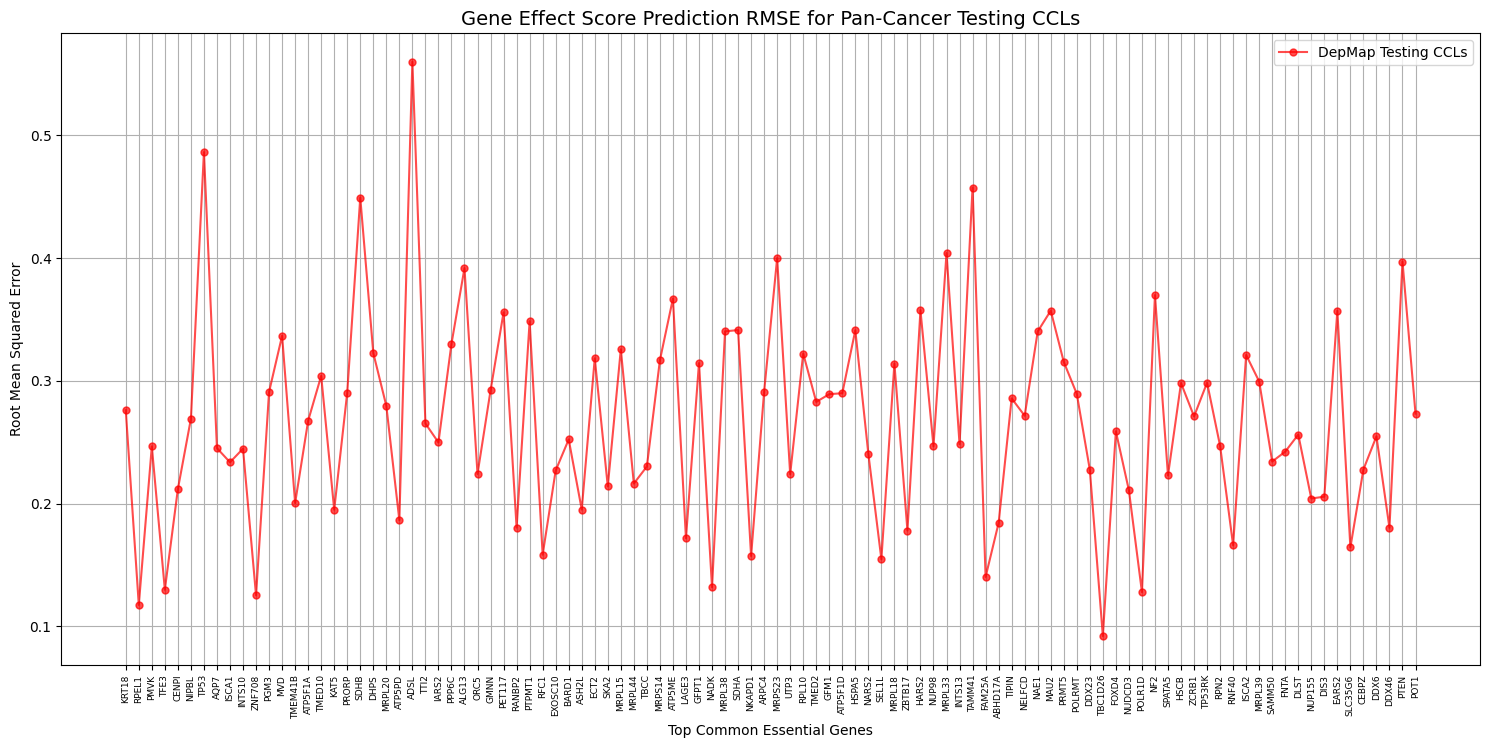

Average RMSE for predicted gene effect scores on testing subset of DepMap CCLs: 0.2681


In [9]:
lf.LinePlot(depmap_top100_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="Gene Effect Score Prediction RMSE for Pan-Cancer Testing CCLs",
            legend_titles={"RMSE": "DepMap Testing CCLs"})

print("Average RMSE for predicted gene effect scores on testing subset of DepMap CCLs: {0:.4}".format(depmap_top100_essential_gene_RMSE["RMSE"].mean()))

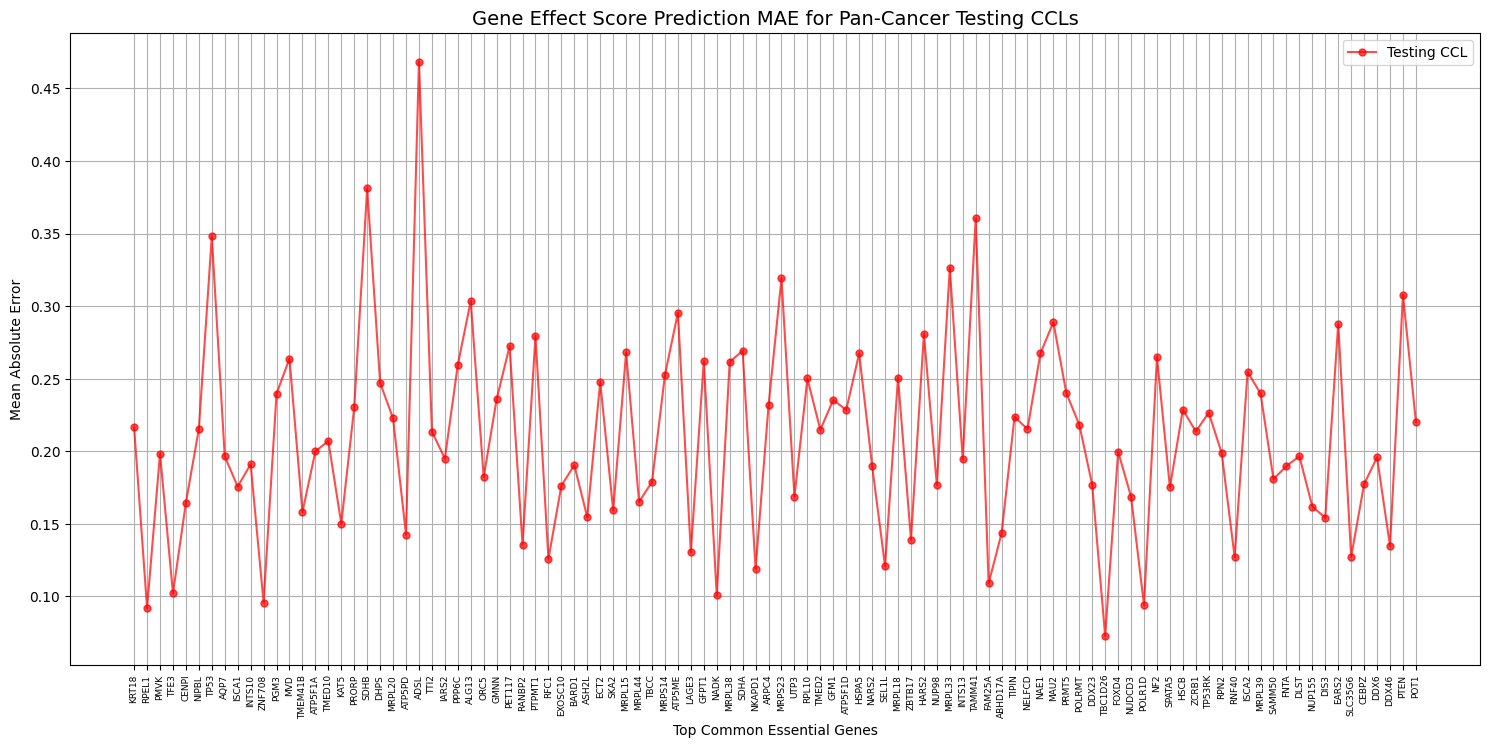

Average RMSE for predicted gene effect scores on testing subset of DepMap CCLs: 0.2098


In [11]:
pred_MAE = lf.PredGeneMAE(depmap_Y_test, depmap_top100_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_MAE, 
            {"MAE": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "Mean Absolute Error"], 
            main_title="Gene Effect Score Prediction MAE for Pan-Cancer Testing CCLs",
            legend_titles={"MAE": "Testing CCL"})

print("Average MAE for predicted gene effect scores on testing subset of DepMap CCLs: {0:.4}".format(pred_MAE["MAE"].mean()))

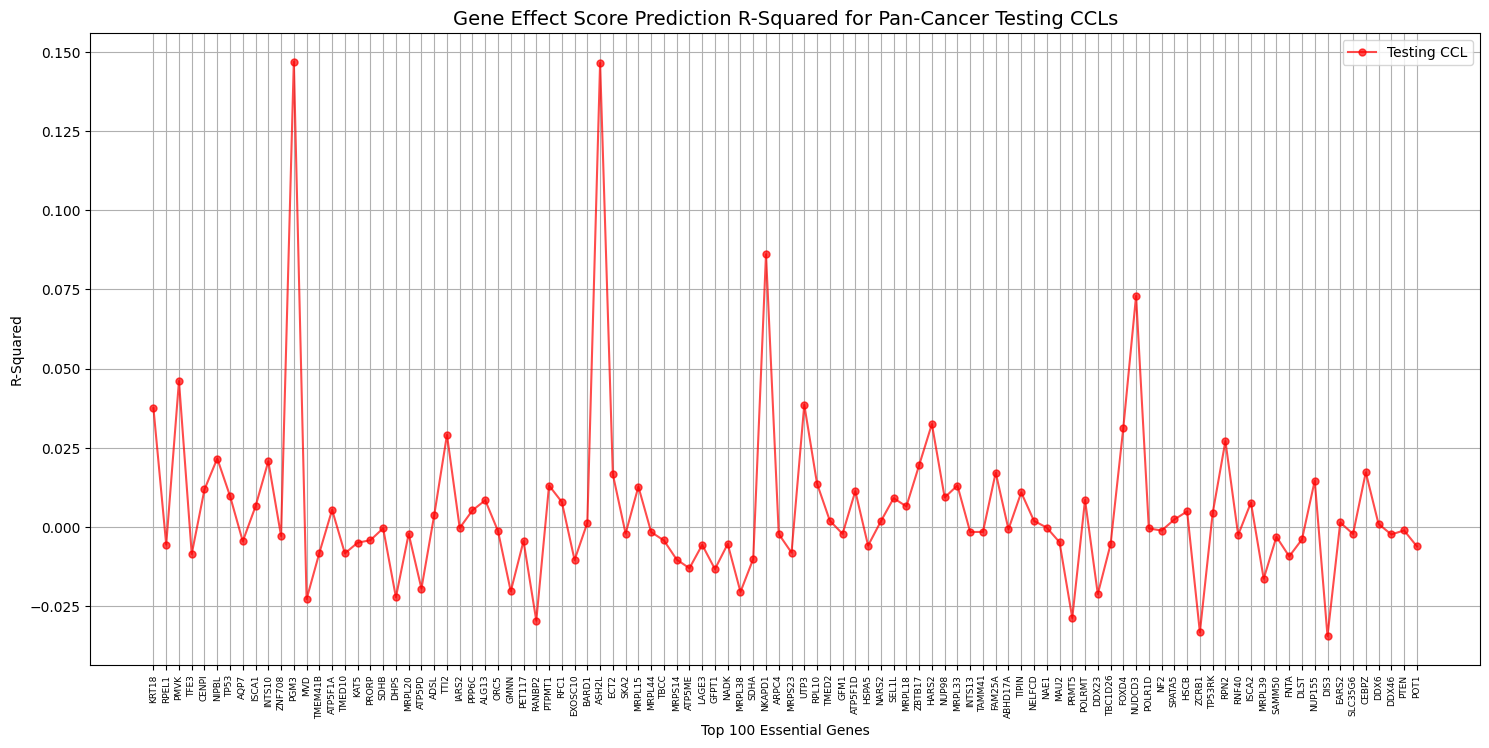

Average RSquared for predicted gene effect scores on testing subset of DepMap CCLs: 0.005474


In [44]:
pred_RSquared = lf.PredGeneRSquared(depmap_Y_test, depmap_top100_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_RSquared, 
            {"R-Squared": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "R-Squared"], 
            main_title="Gene Effect Score Prediction R-Squared for Pan-Cancer Testing CCLs",
            legend_titles={"R-Squared": "Testing CCL"})

print("Average RSquared for predicted gene effect scores on testing subset of DepMap CCLs: {0:.4}".format(pred_RSquared["R-Squared"].mean()))

### Linear Models across RCC DepMap CCLs Training/Testing subsets

In [14]:
RCC_top_100_essential_gene_linearity = lf.GeneLinearity(RCC_X_train, RCC_Y_train, top100_essential_genes)

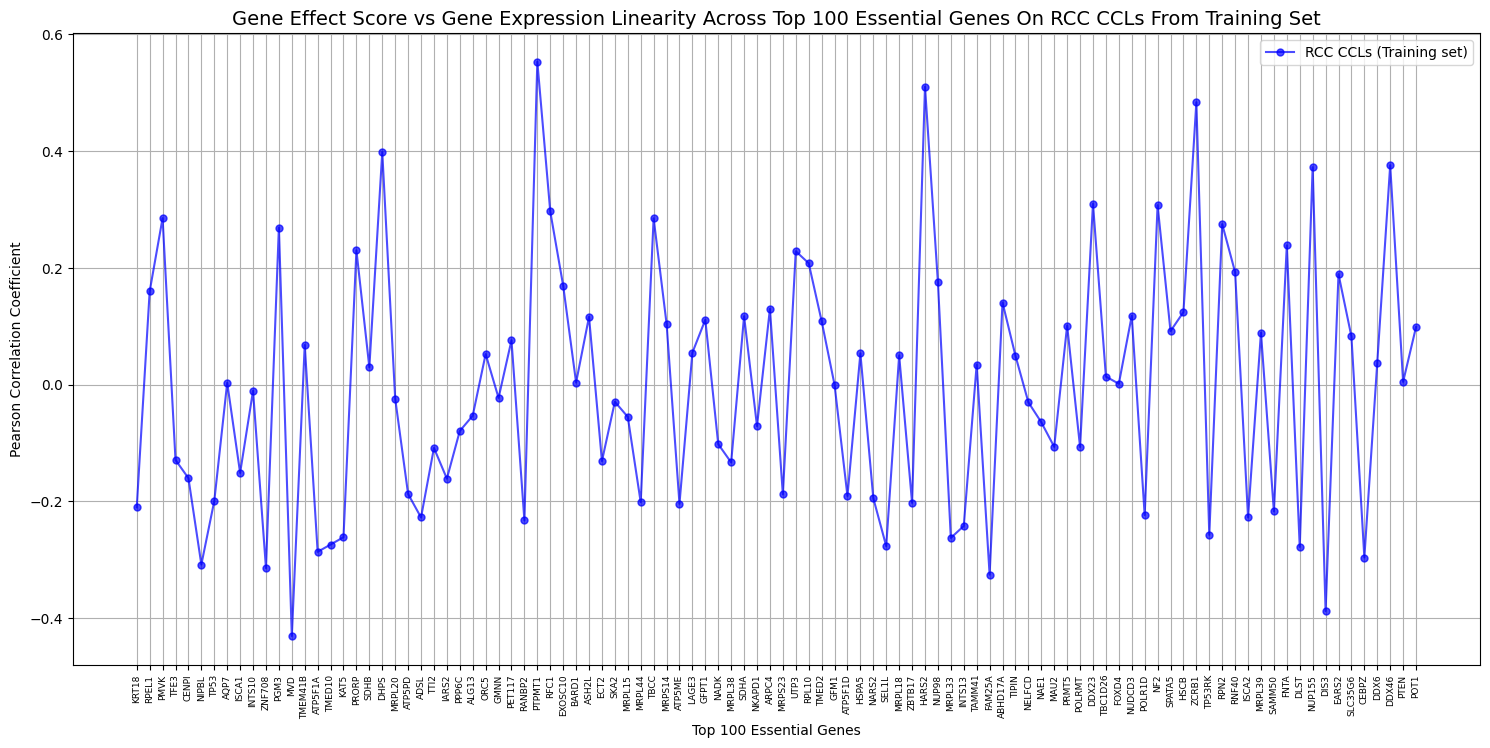

Mean Pearson Correlation Coefficients across top 100 essential genes: 0.17405519855107726


In [15]:
lf.LinePlot(RCC_top_100_essential_gene_linearity, 
            {"Linearity": "blue"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Pearson Correlation Coefficient"], 
            main_title="Gene Effect Score vs Gene Expression Linearity Across Top 100 Essential Genes On RCC CCLs From Training Set",
            legend_titles={"corr": "RCC CCLs (Training set)"})

print("Mean Pearson Correlation Coefficients across top 100 essential genes: {0}".format(abs(RCC_top_100_essential_gene_linearity["corr"]).mean()))

In [16]:
RCC_top100_essential_gene_models = lf.ComputeGeneLinearModels(RCC_X_train, RCC_Y_train, top100_essential_genes)
RCC_top100_essential_gene_preds, RCC_top100_essential_gene_RMSE = lf.ComputeGenePredictions(RCC_X_test, RCC_Y_test, RCC_top100_essential_gene_models)

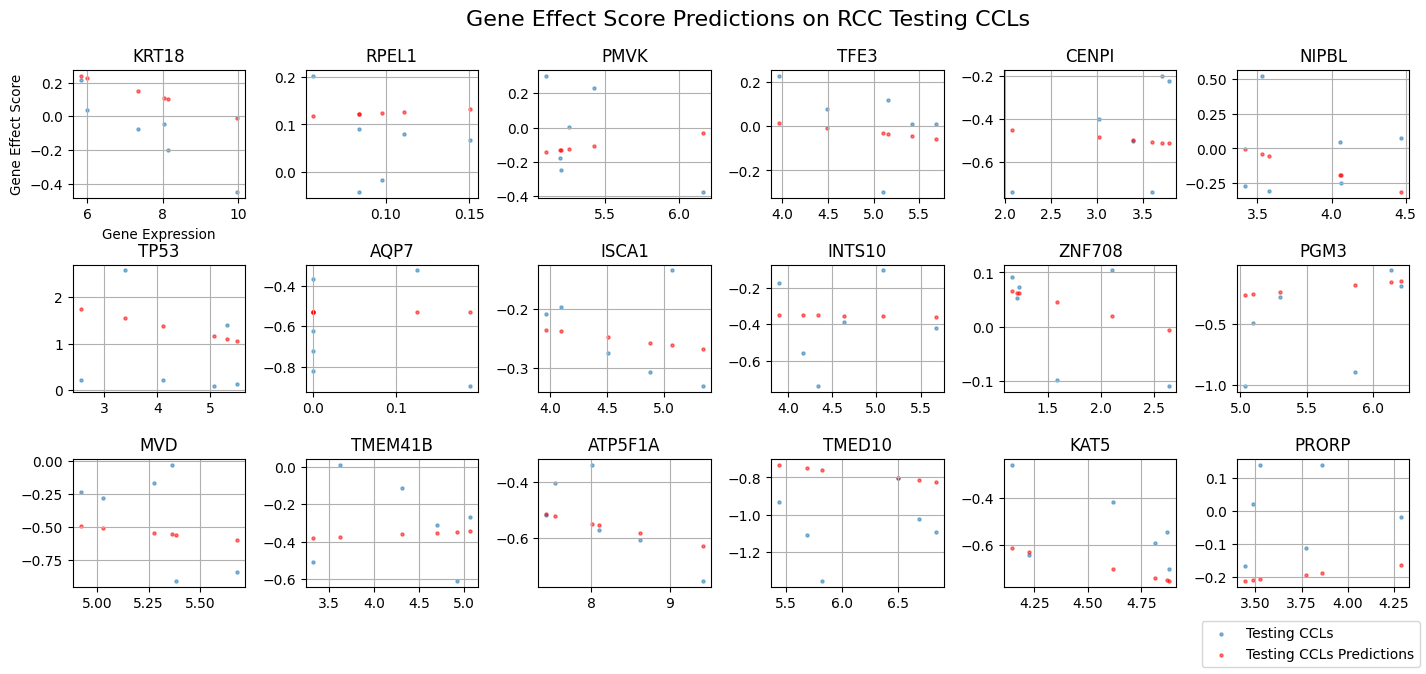

In [46]:
lf.GeneRelMiniPlot(RCC_X_test, RCC_Y_test, top100_essential_genes[:18],
                   rel2_X=RCC_X_test,
                   rel2_Y=RCC_top100_essential_gene_preds,
                   main_title="Gene Effect Score Predictions on RCC Testing CCLs",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "Testing CCLs", "rel2": "Testing CCLs Predictions"},
                   sizeProps=[0.89, 0.125, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

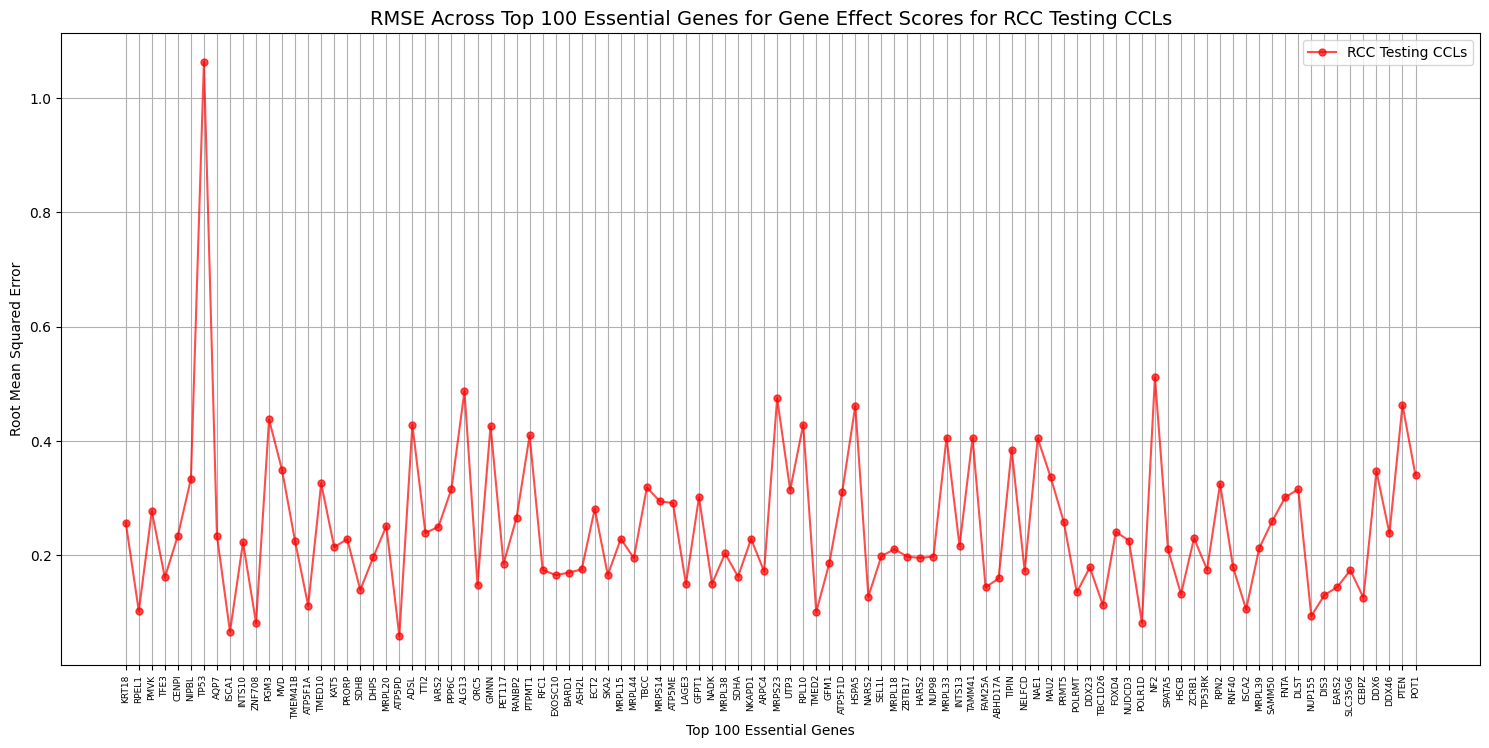

Average RMSE for predicted gene effect scores on testing subset of RCC CCLs: 0.2479


In [19]:
lf.LinePlot(RCC_top100_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="RMSE Across Top 100 Essential Genes for Gene Effect Scores for RCC Testing CCLs",
            legend_titles={"RMSE": "RCC Testing CCLs"})

print("Average RMSE for predicted gene effect scores on testing subset of RCC CCLs: {0:.4}".format(RCC_top100_essential_gene_RMSE["RMSE"].mean()))

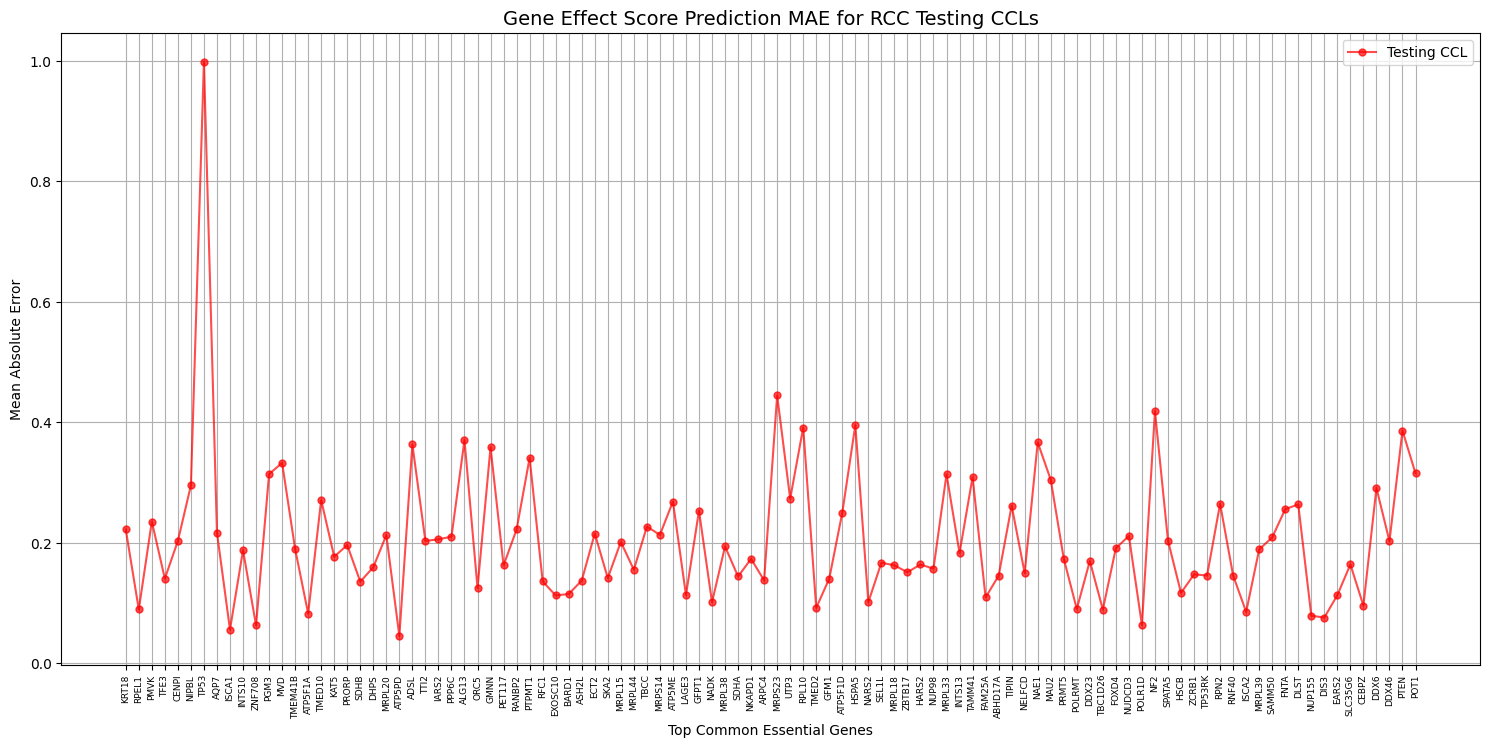

Average MAE for predicted gene effect scores on testing subset of RCC CCLs: 0.2062


In [18]:
pred_MAE = lf.PredGeneMAE(RCC_Y_test, RCC_top100_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_MAE, 
            {"MAE": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "Mean Absolute Error"], 
            main_title="Gene Effect Score Prediction MAE for RCC Testing CCLs",
            legend_titles={"MAE": "Testing CCL"})

print("Average MAE for predicted gene effect scores on testing subset of RCC CCLs: {0:.4}".format(pred_MAE["MAE"].mean()))

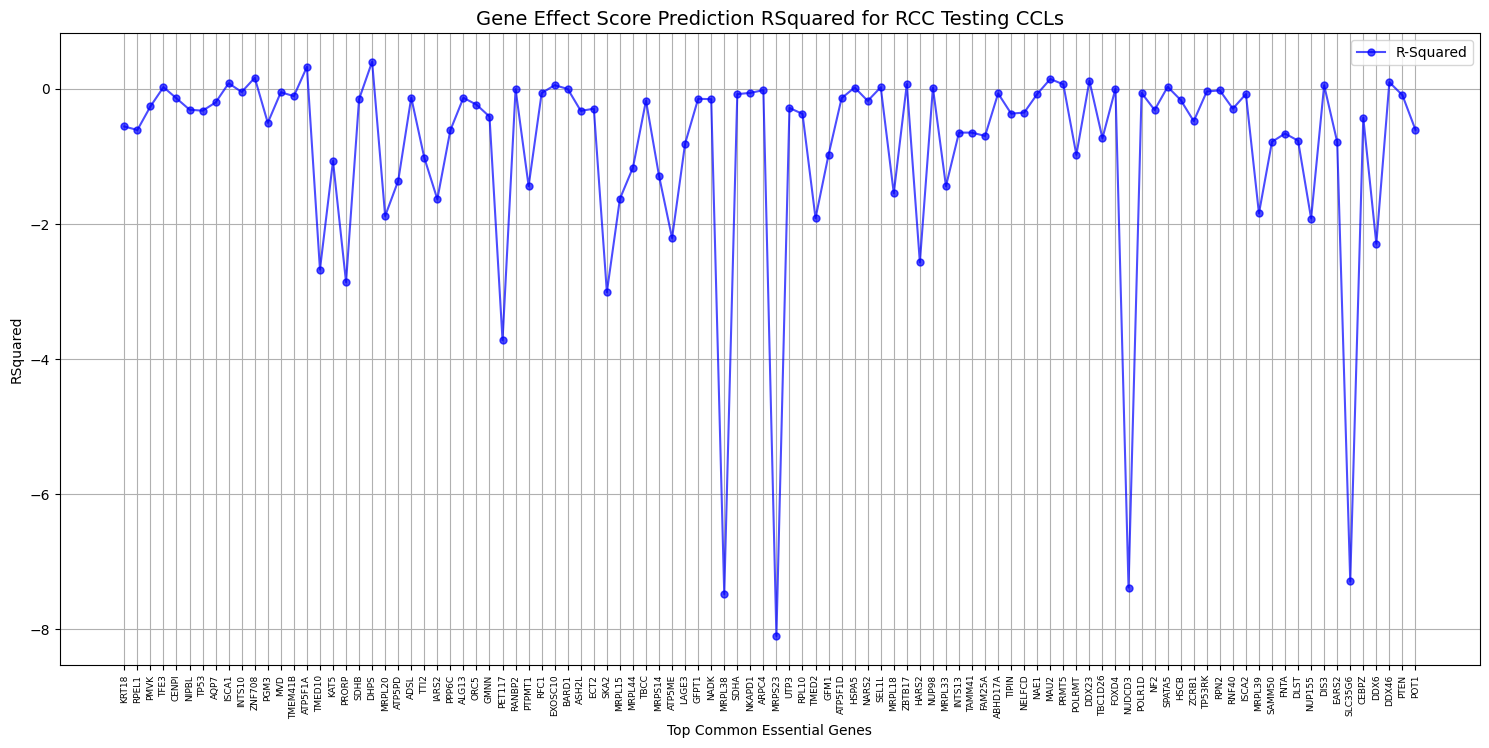

Average RSquared for predicted gene effect scores on testing subset of RCC CCLs: -0.8834


In [20]:
pred_RSquared = lf.PredGeneRSquared(RCC_Y_test, RCC_top100_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_RSquared, 
            {"RSquared": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "RSquared"], 
            main_title="Gene Effect Score Prediction RSquared for RCC Testing CCLs",
            legend_titles={"RSquared": "Testing CCL"})

print("Average RSquared for predicted gene effect scores on testing subset of RCC CCLs: {0:.4}".format(pred_RSquared["R-Squared"].mean()))

### Linear Models across ccRCC DepMap CCLs Training/Testing subsets

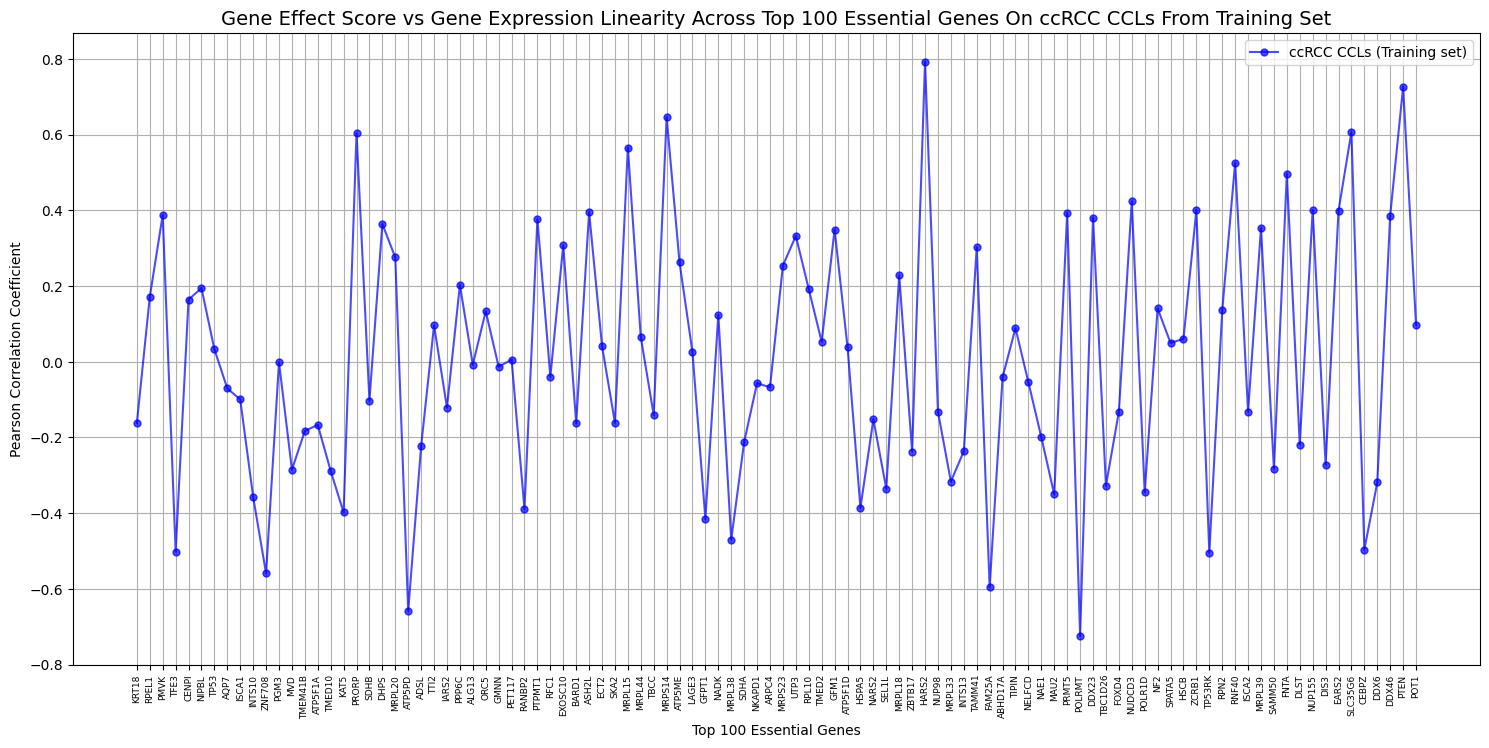

Mean Pearson Correlation Coefficients across top 100 essential genes: 0.2715318866511475


In [22]:
ccRCC_top_100_essential_gene_linearity = lf.GeneLinearity(ccRCC_X_train, ccRCC_Y_train, top100_essential_genes)

lf.LinePlot(ccRCC_top_100_essential_gene_linearity, 
            {"Linearity": "blue"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Pearson Correlation Coefficient"], 
            main_title="Gene Effect Score vs Gene Expression Linearity Across Top 100 Essential Genes On ccRCC CCLs From Training Set",
            legend_titles={"corr": "ccRCC CCLs (Training set)"})

print("Mean Pearson Correlation Coefficients across top 100 essential genes: {0}".format(abs(ccRCC_top_100_essential_gene_linearity["corr"]).mean()))

In [23]:
ccRCC_top100_essential_gene_models = lf.ComputeGeneLinearModels(ccRCC_X_train, ccRCC_Y_train, top100_essential_genes)
ccRCC_top100_essential_gene_preds, ccRCC_top100_essential_gene_RMSE = lf.ComputeGenePredictions(ccRCC_X_test, ccRCC_Y_test, ccRCC_top100_essential_gene_models)

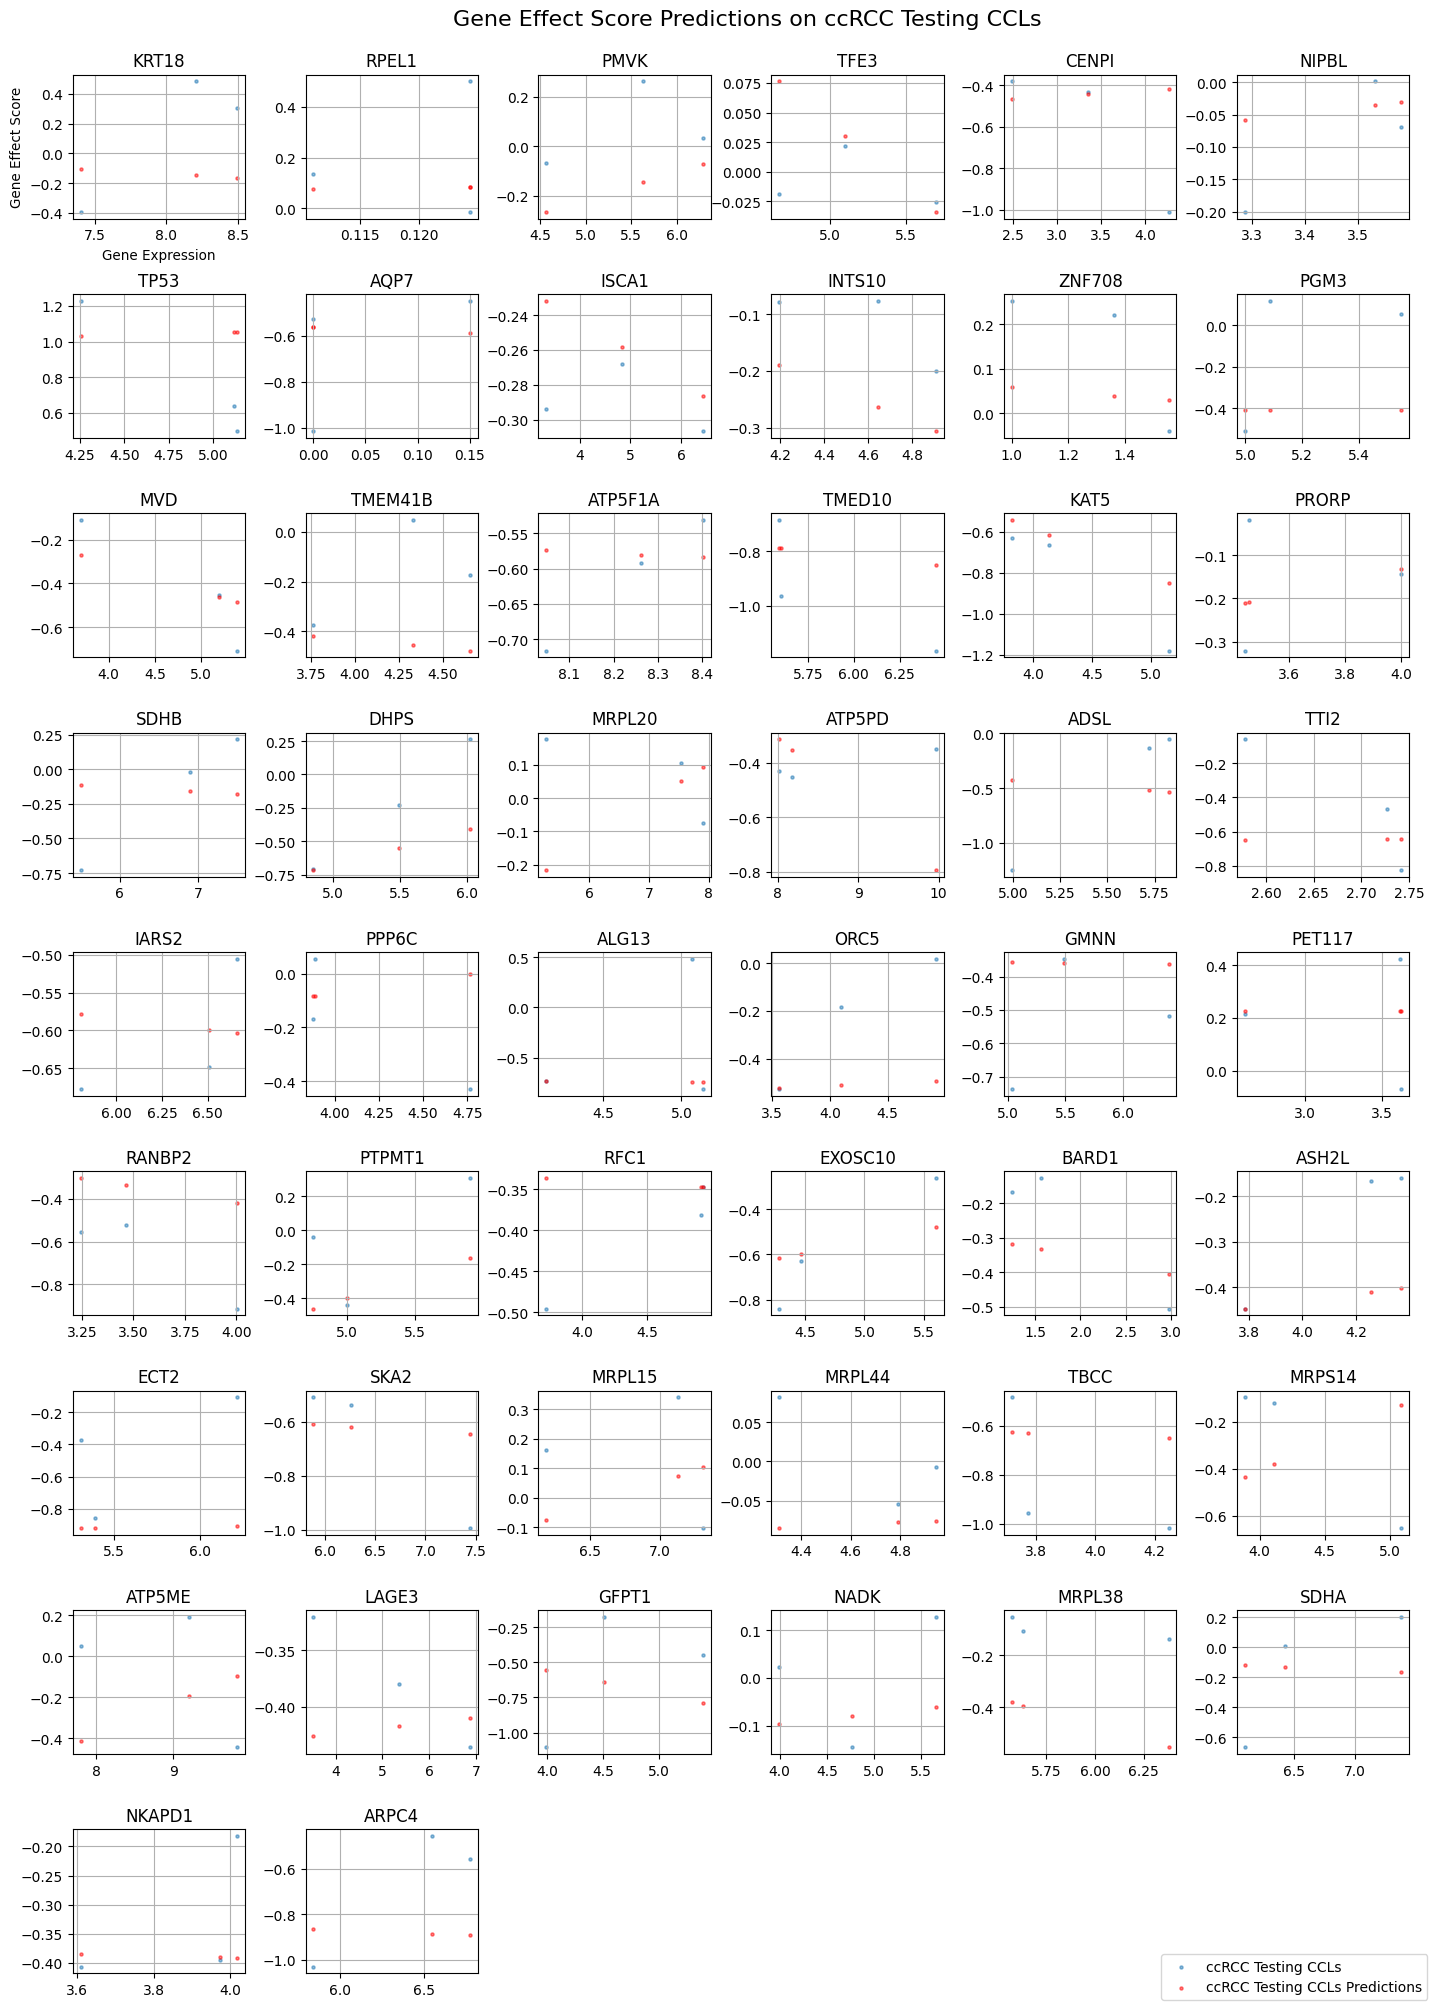

In [24]:
lf.GeneRelMiniPlot(ccRCC_X_test, ccRCC_Y_test, top100_essential_genes[:50],
                   rel2_X=ccRCC_X_test,
                   rel2_Y=ccRCC_top100_essential_gene_preds,
                   main_title="Gene Effect Score Predictions on ccRCC Testing CCLs",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "ccRCC Testing CCLs", "rel2": "ccRCC Testing CCLs Predictions"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

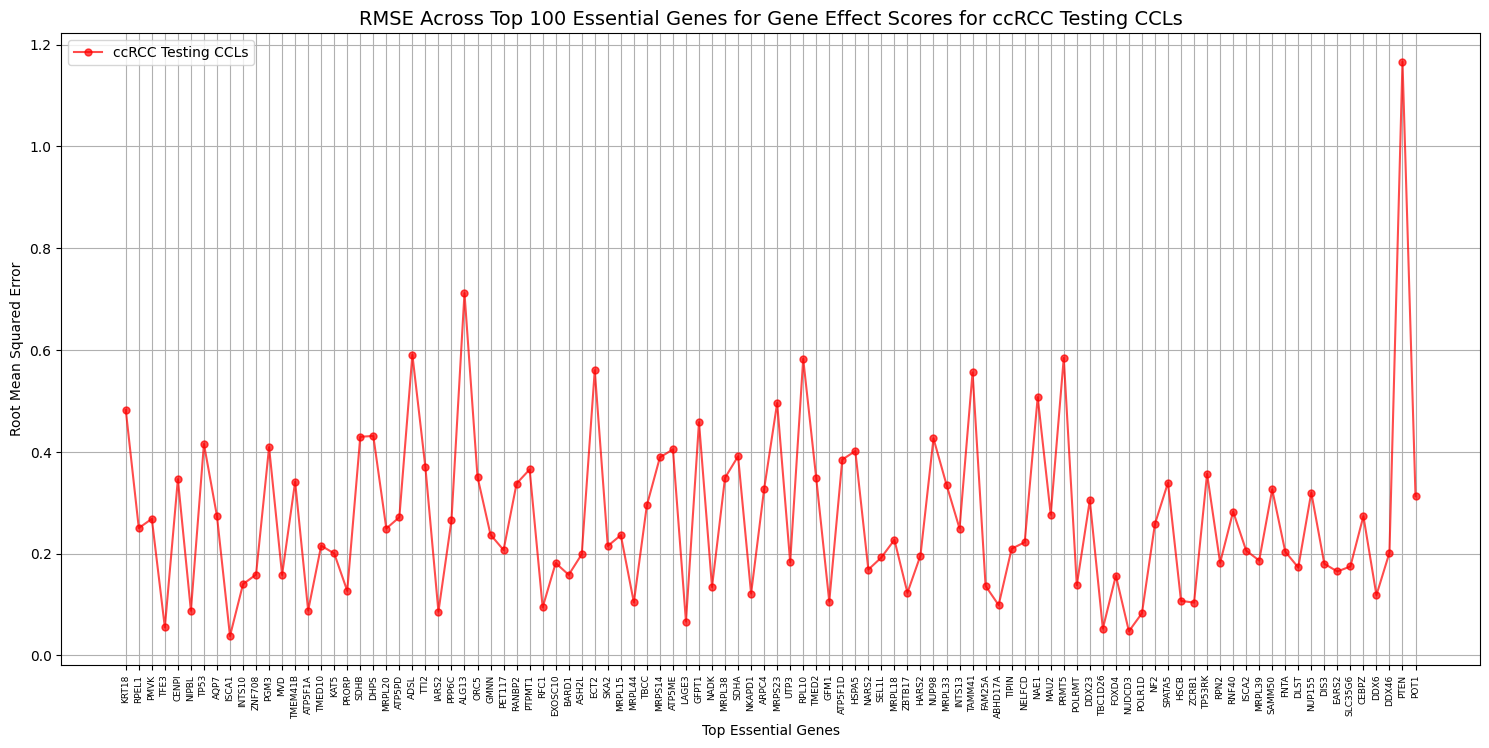

Average RMSE for predicted gene effect scores on testing subset of ccRCC CCLs: 0.2707


In [25]:
lf.LinePlot(ccRCC_top100_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="RMSE Across Top 100 Essential Genes for Gene Effect Scores for ccRCC Testing CCLs",
            legend_titles={"RMSE": "ccRCC Testing CCLs"})

print("Average RMSE for predicted gene effect scores on testing subset of ccRCC CCLs: {0:.4}".format(ccRCC_top100_essential_gene_RMSE["RMSE"].mean()))

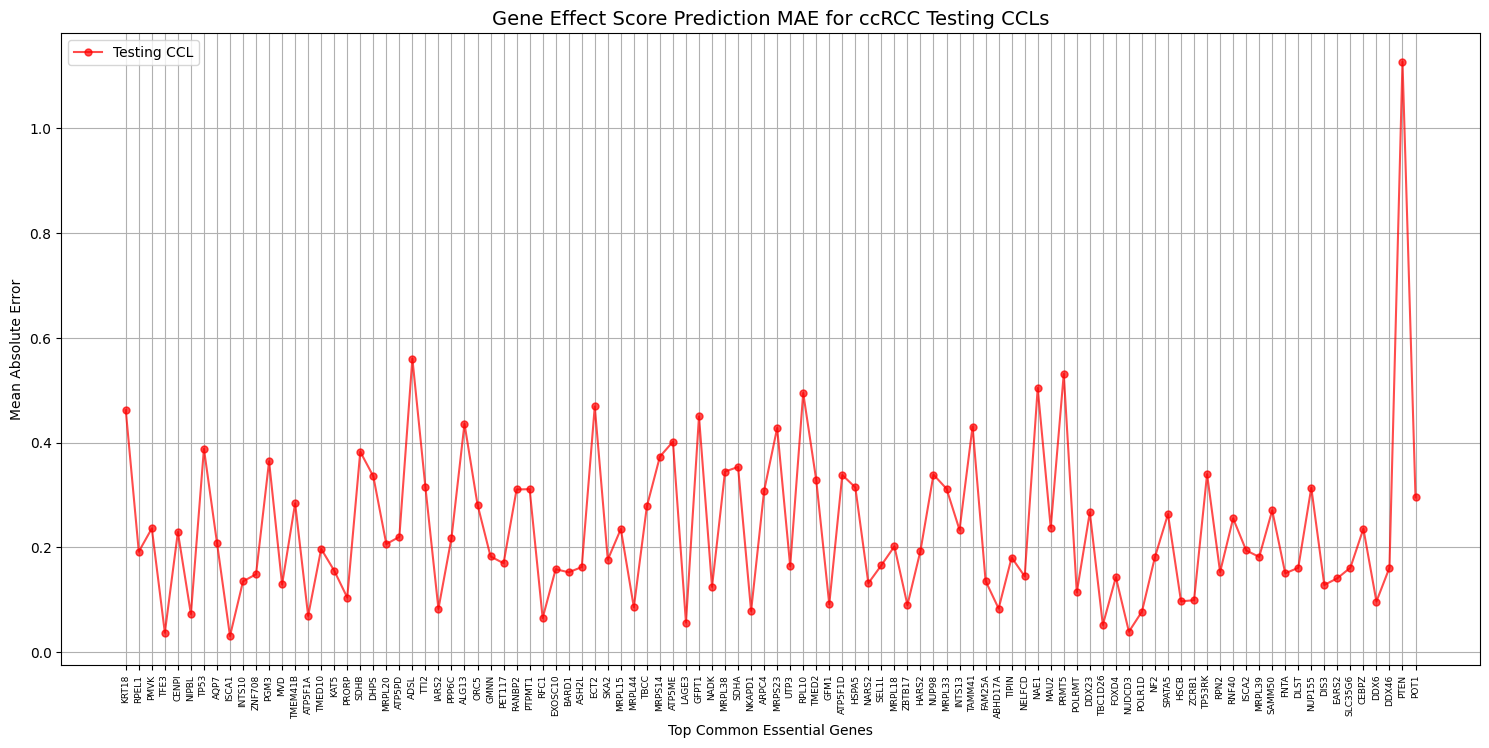

Average MAE for predicted gene effect scores on testing subset of ccRCC CCLs: 0.235


In [26]:
pred_MAE = lf.PredGeneMAE(ccRCC_Y_test, ccRCC_top100_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_MAE, 
            {"MAE": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "Mean Absolute Error"], 
            main_title="Gene Effect Score Prediction MAE for ccRCC Testing CCLs",
            legend_titles={"MAE": "Testing CCL"})

print("Average MAE for predicted gene effect scores on testing subset of ccRCC CCLs: {0:.4}".format(pred_MAE["MAE"].mean()))

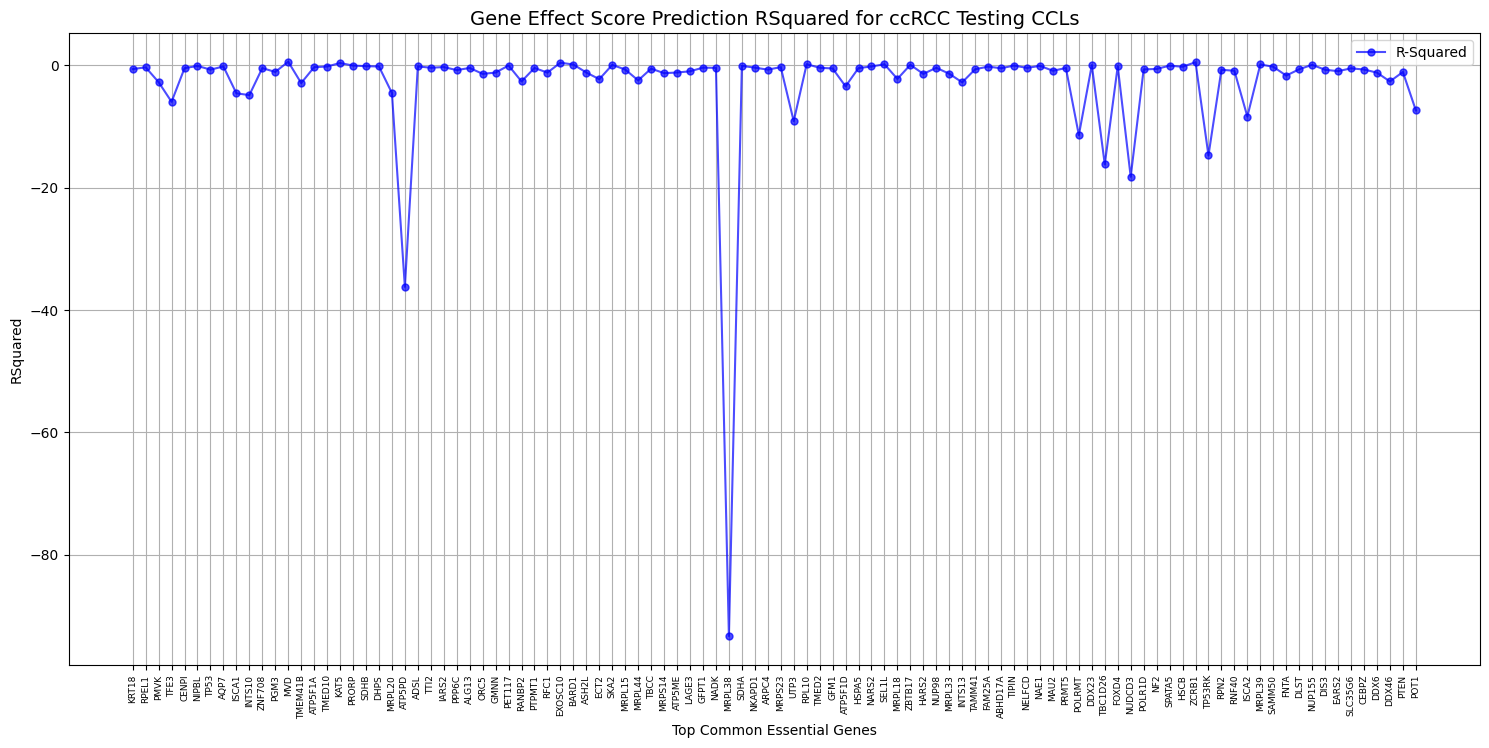

Average RSquared for predicted gene effect scores on testing subset of ccRCC CCLs: -2.949


In [27]:
pred_RSquared = lf.PredGeneRSquared(ccRCC_Y_test, ccRCC_top100_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_RSquared, 
            {"RSquared": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "RSquared"], 
            main_title="Gene Effect Score Prediction RSquared for ccRCC Testing CCLs",
            legend_titles={"RSquared": "Testing CCL"})

print("Average RSquared for predicted gene effect scores on testing subset of ccRCC CCLs: {0:.4}".format(pred_RSquared["R-Squared"].mean()))

## DepMap Trained Linear Models on tRCC CCLs

### Full DepMap Linear Models tRCC Gene Effect Score Predictions

In [28]:
depmap_tRCC_essential_gene_preds, depmap_tRCC_essential_gene_RMSE = lf.ComputeGenePredictions(tRCC_gene_exp, tRCC_chronos_gene_effects, depmap_top100_essential_gene_models)

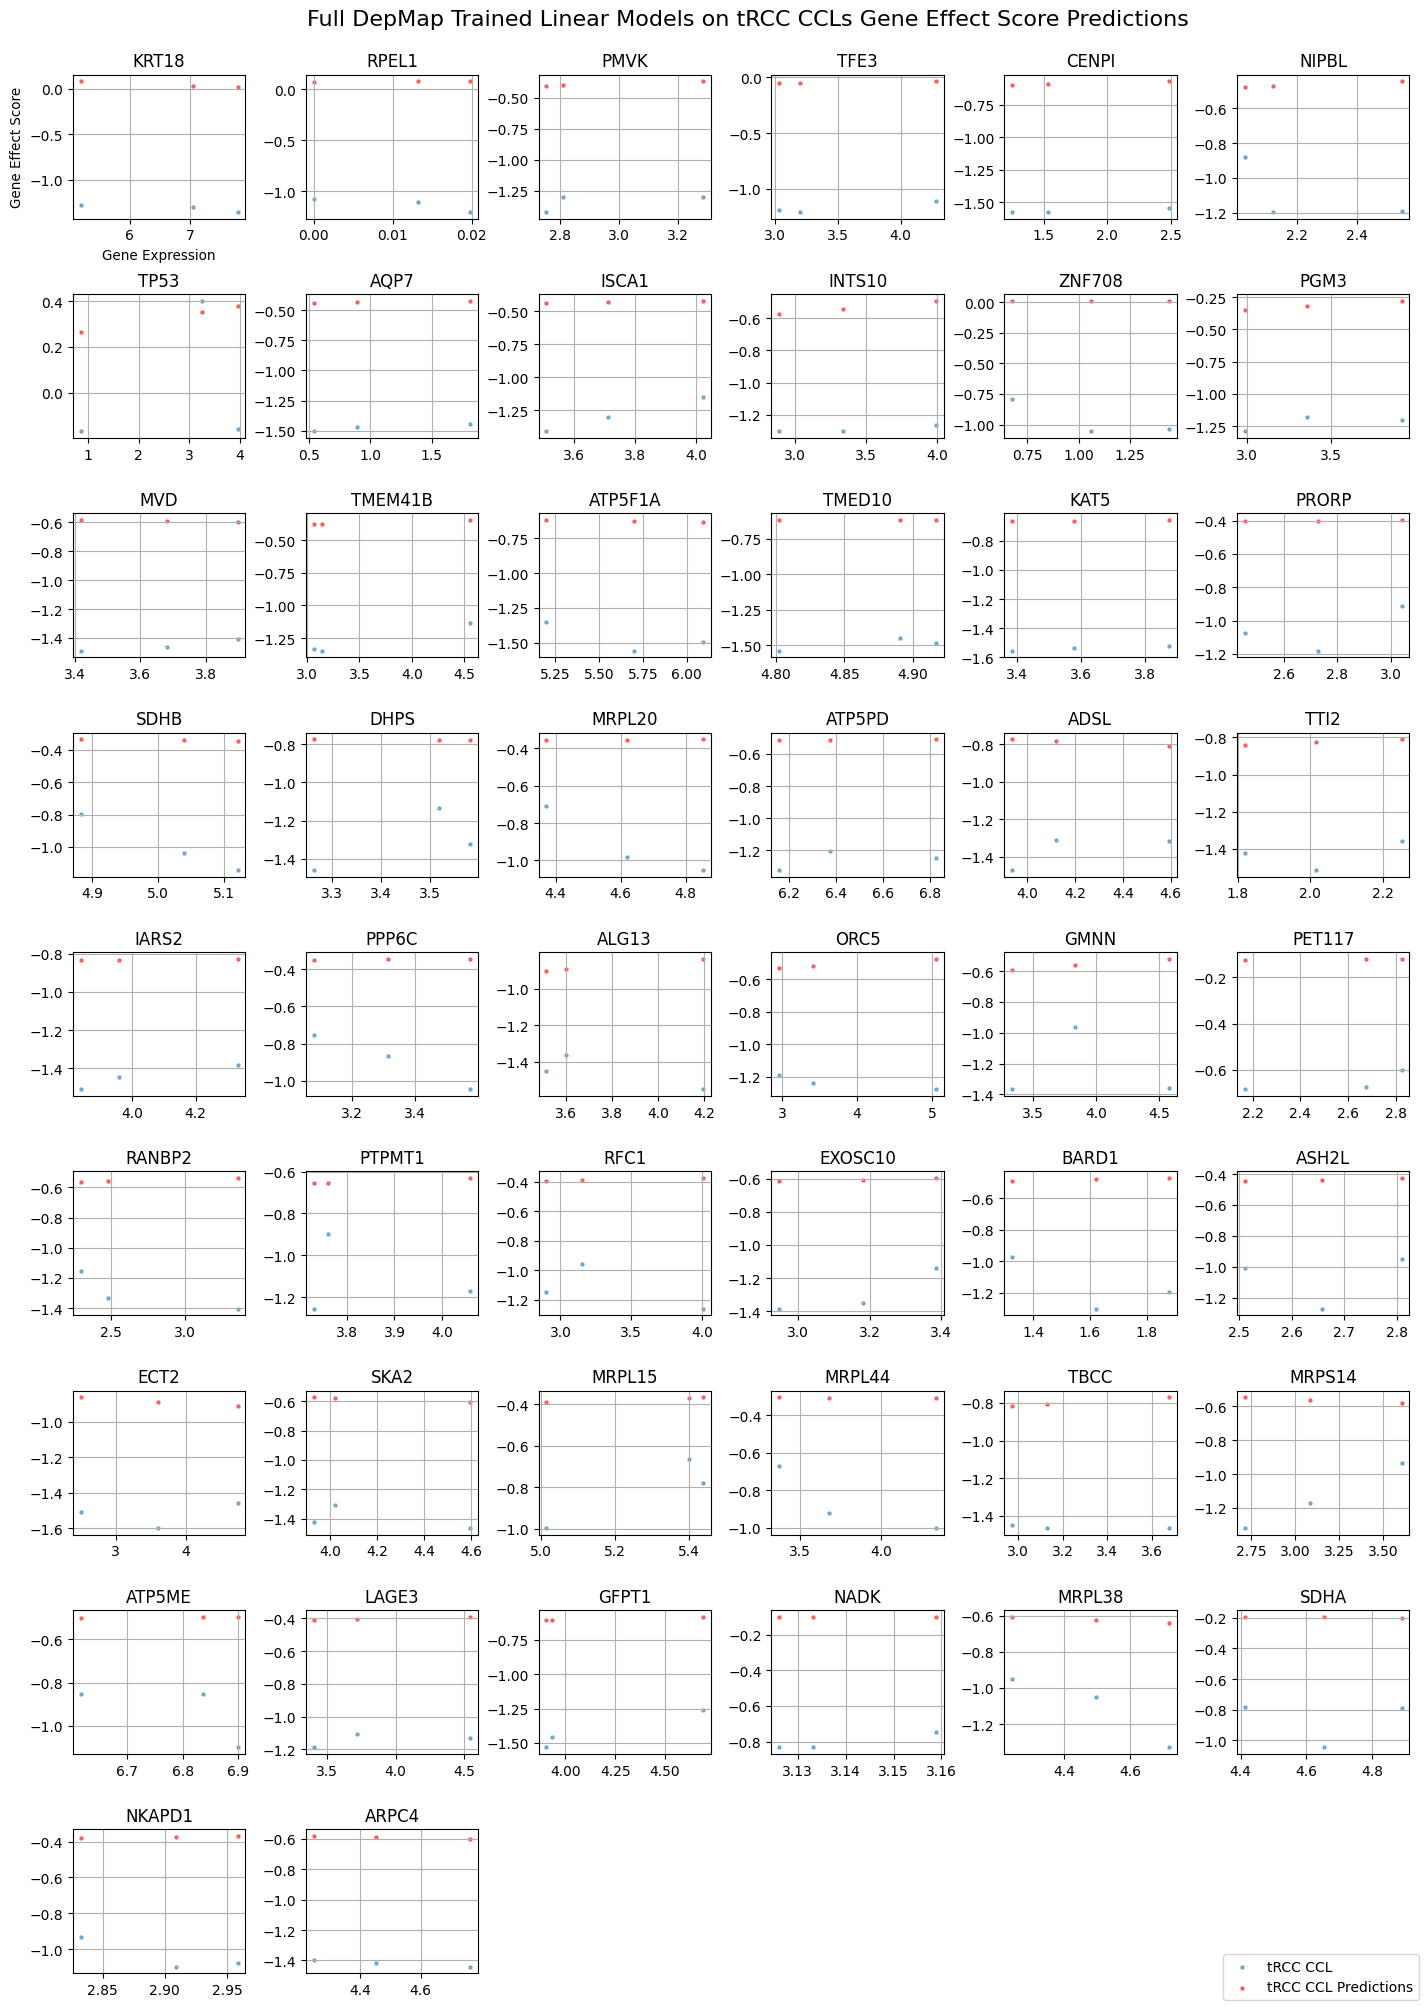

In [29]:
lf.GeneRelMiniPlot(tRCC_gene_exp, tRCC_chronos_gene_effects, top100_essential_genes[:50],
                   rel2_X=tRCC_gene_exp,
                   rel2_Y=depmap_tRCC_essential_gene_preds,
                   main_title="Full DepMap Trained Linear Models on tRCC CCLs Gene Effect Score Predictions",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "tRCC CCL", "rel2": "tRCC CCL Predictions"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

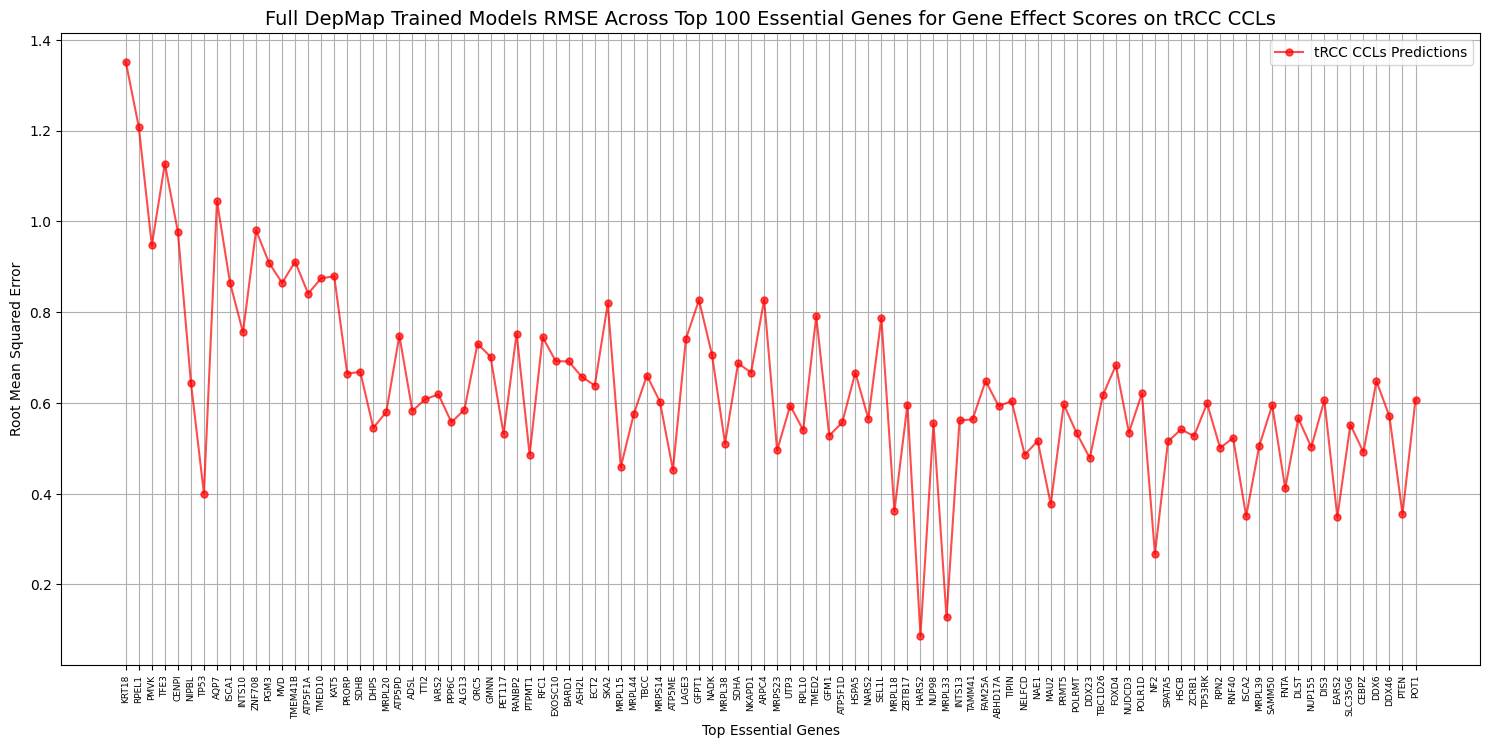

Average RMSE for predicted gene effect scores on tRCC CCLs: 0.6315


In [30]:
lf.LinePlot(depmap_tRCC_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="Full DepMap Trained Models RMSE Across Top 100 Essential Genes for Gene Effect Scores on tRCC CCLs",
            legend_titles={"RMSE": "tRCC CCLs Predictions"})

print("Average RMSE for predicted gene effect scores on tRCC CCLs: {0:.4}".format(depmap_tRCC_essential_gene_RMSE["RMSE"].mean()))

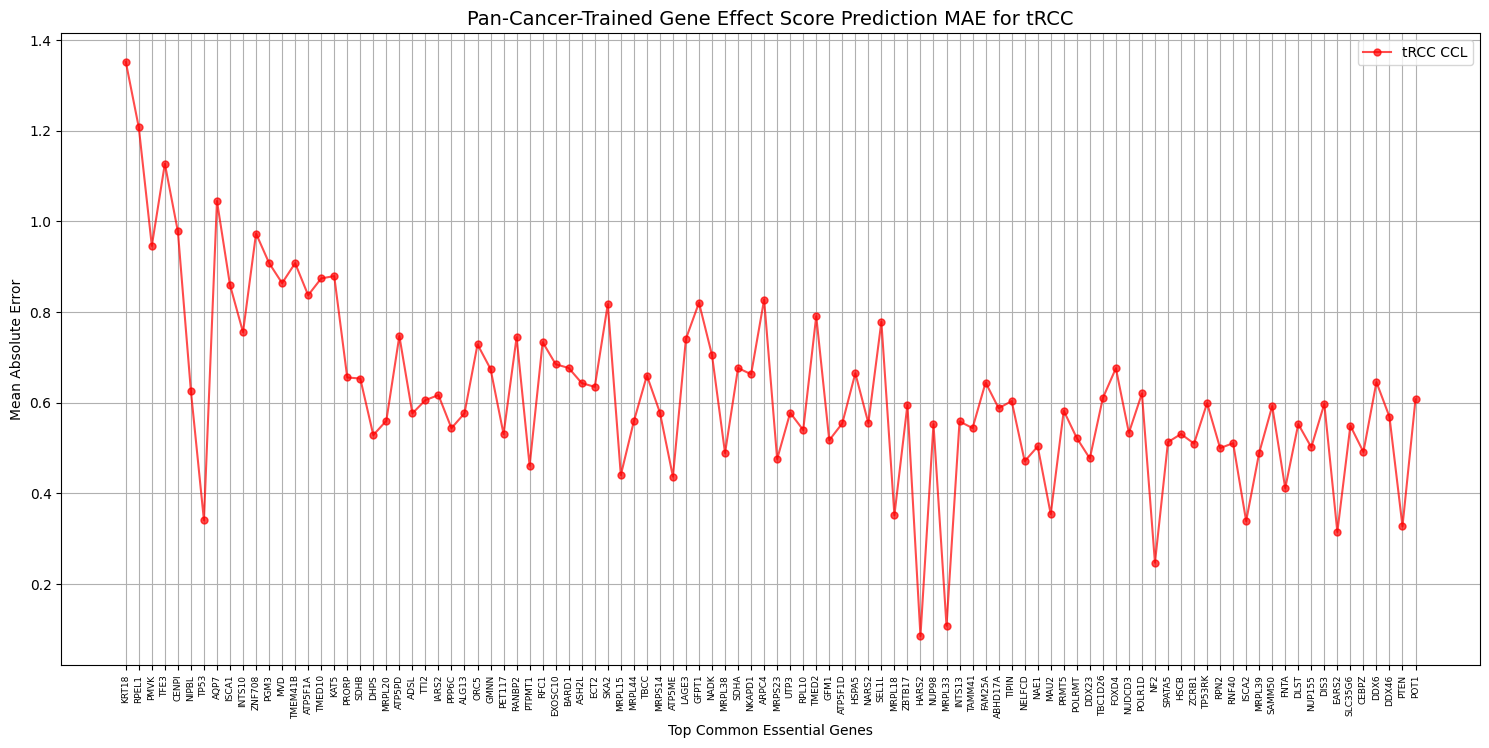

Average MAE for predicted gene effect scores on testing subset of tRCC CCLs: 0.6228


In [31]:
pred_MAE = lf.PredGeneMAE(tRCC_chronos_gene_effects, depmap_tRCC_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_MAE, 
            {"MAE": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "Mean Absolute Error"], 
            main_title="Pan-Cancer-Trained Gene Effect Score Prediction MAE for tRCC",
            legend_titles={"MAE": "tRCC CCL"})

print("Average MAE for predicted gene effect scores on testing subset of tRCC CCLs: {0:.4}".format(pred_MAE["MAE"].mean()))

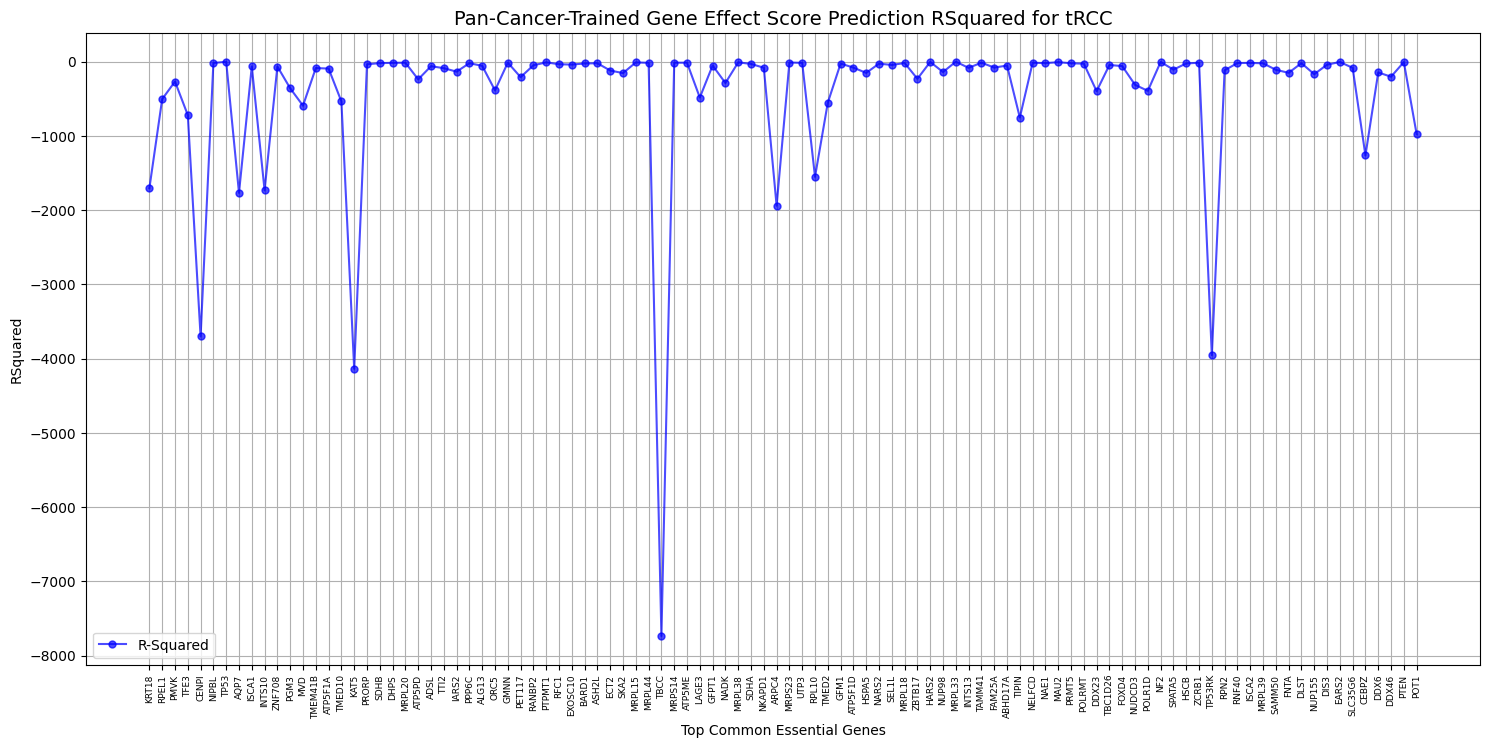

Average RSquared for predicted gene effect scores on testing subset of tRCC CCLs: -413.4


In [32]:
pred_RSquared = lf.PredGeneRSquared(tRCC_chronos_gene_effects, depmap_tRCC_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_RSquared, 
            {"RSquared": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "RSquared"], 
            main_title="Pan-Cancer-Trained Gene Effect Score Prediction RSquared for tRCC",
            legend_titles={"RSquared": "tRCC CCL"})

print("Average RSquared for predicted gene effect scores on testing subset of tRCC CCLs: {0:.4}".format(pred_RSquared["R-Squared"].mean()))

In [47]:
depmap_tRCC_essential_gene_preds["TBCC"]

FUUR1    -0.807481
STFE     -0.770475
UOK109   -0.818225
Name: TBCC, dtype: float64

In [48]:
tRCC_chronos_gene_effects["TBCC"]

FUUR1    -1.462326
STFE     -1.464970
UOK109   -1.447892
Name: TBCC, dtype: float64

### RCC CCLs Linear Models tRCC Gene Effect Score Predictions

In [33]:
RCC_tRCC_essential_gene_preds, RCC_tRCC_essential_gene_RMSE = lf.ComputeGenePredictions(tRCC_gene_exp, tRCC_chronos_gene_effects, RCC_top100_essential_gene_models)

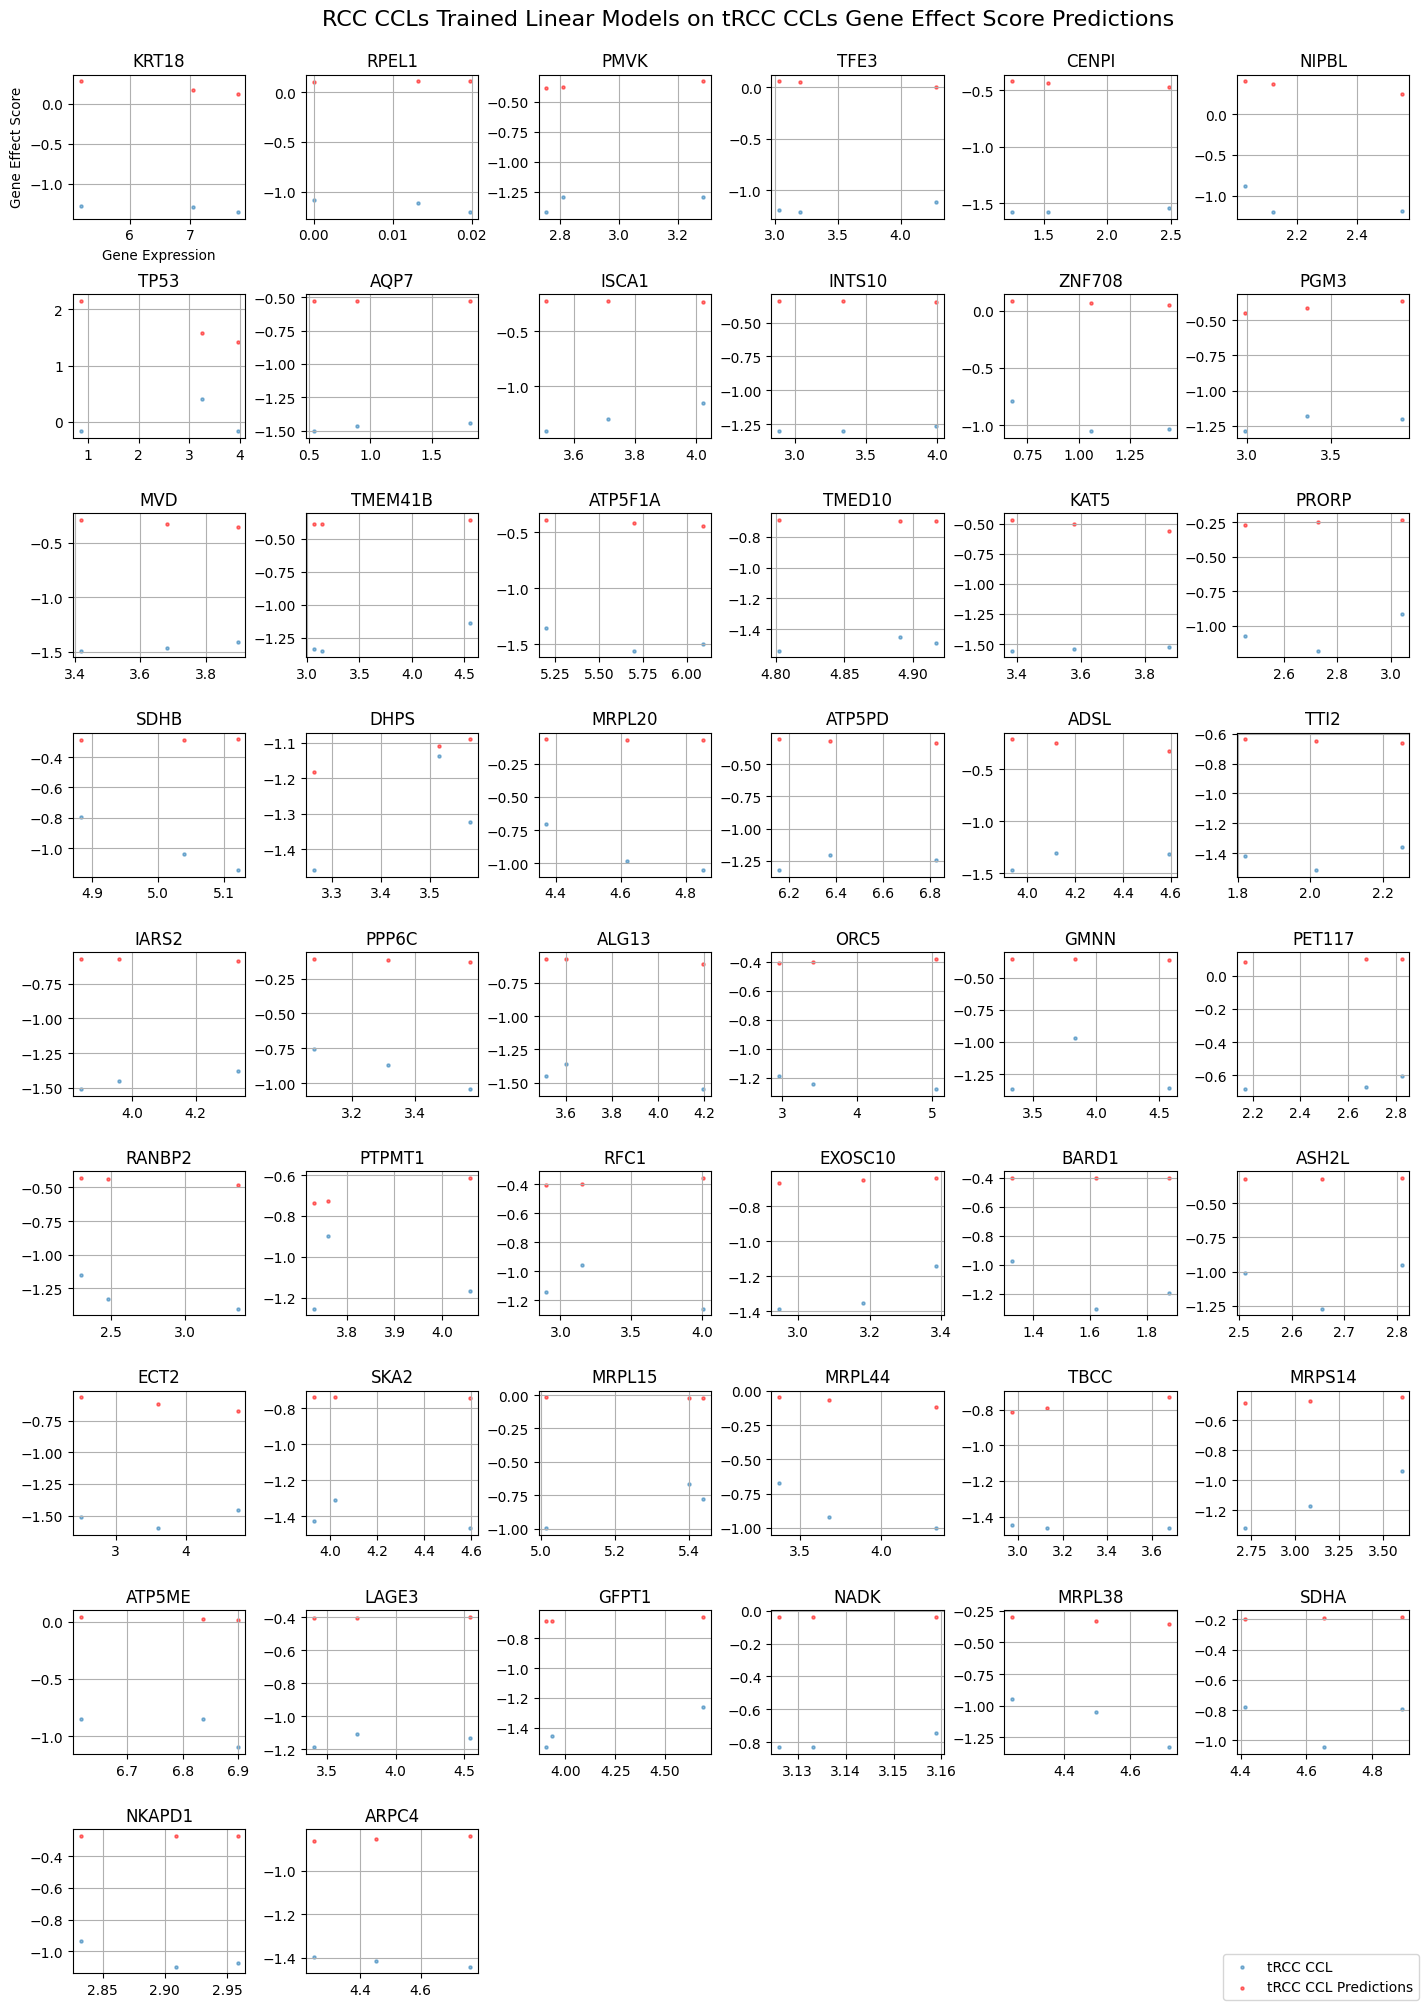

In [34]:
lf.GeneRelMiniPlot(tRCC_gene_exp, tRCC_chronos_gene_effects, top100_essential_genes[:50],
                   rel2_X=tRCC_gene_exp,
                   rel2_Y=RCC_tRCC_essential_gene_preds,
                   main_title="RCC CCLs Trained Linear Models on tRCC CCLs Gene Effect Score Predictions",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "tRCC CCL", "rel2": "tRCC CCL Predictions"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

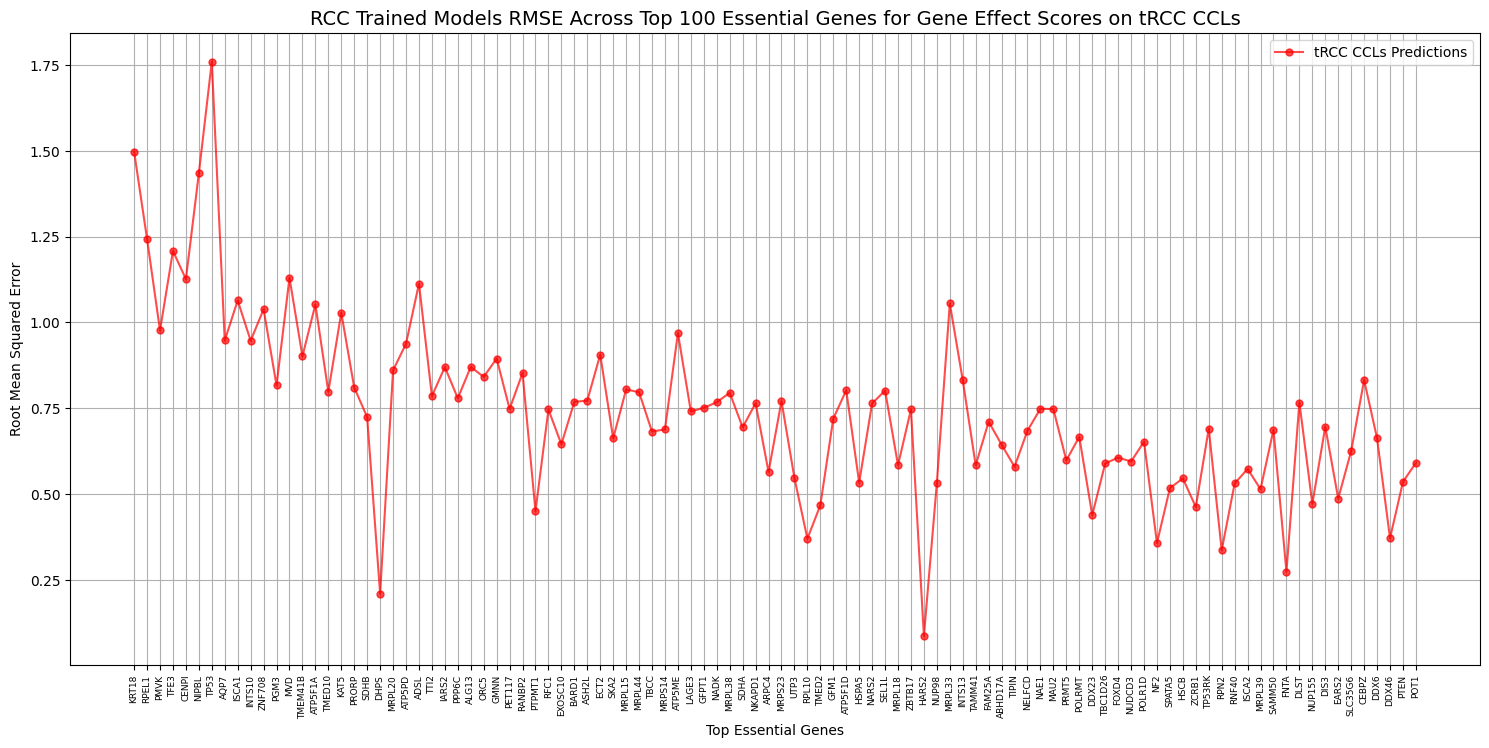

Average RMSE for predicted gene effect scores on tRCC CCLs: 0.742


In [35]:
lf.LinePlot(RCC_tRCC_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="RCC Trained Models RMSE Across Top 100 Essential Genes for Gene Effect Scores on tRCC CCLs",
            legend_titles={"RMSE": "tRCC CCLs Predictions"})

print("Average RMSE for predicted gene effect scores on tRCC CCLs: {0:.4}".format(RCC_tRCC_essential_gene_RMSE["RMSE"].mean()))

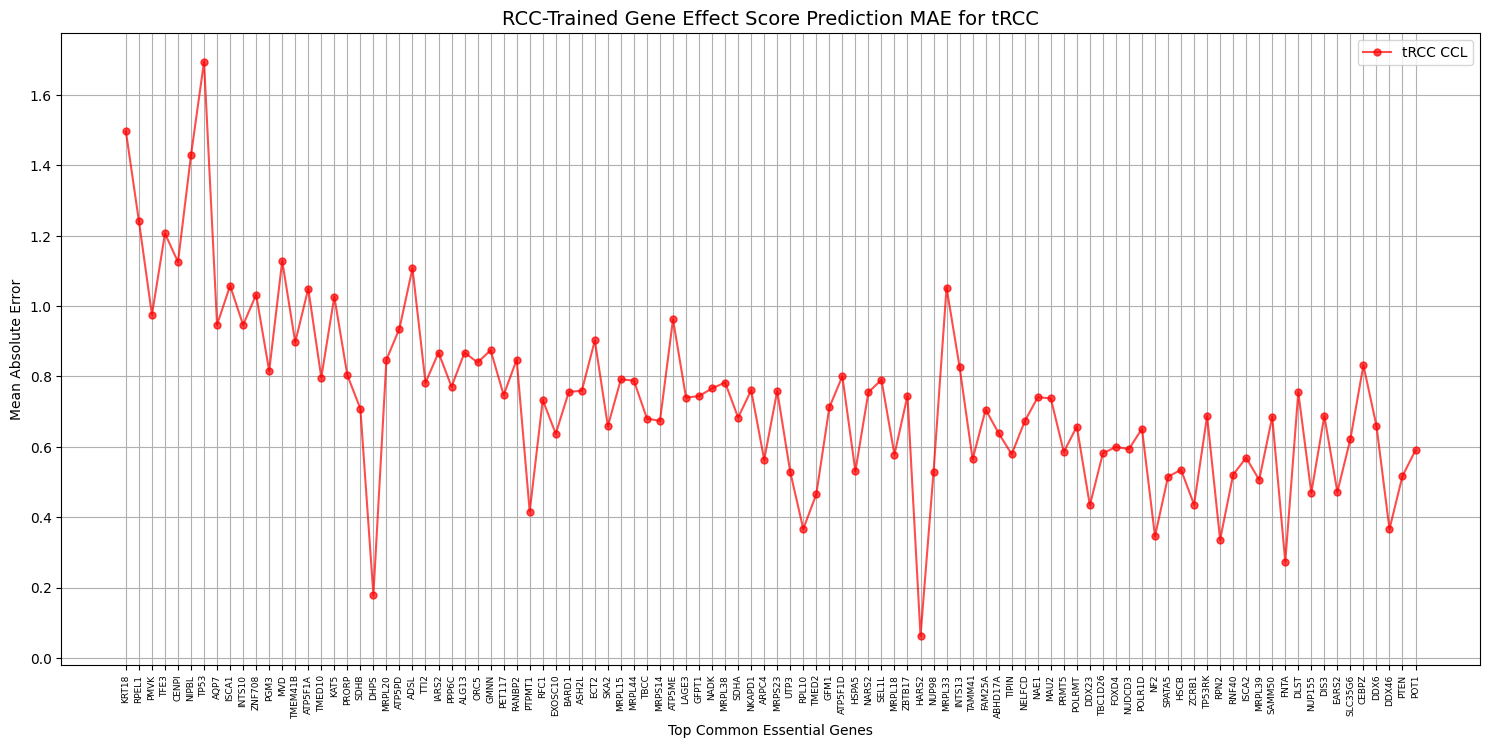

Average MAE for predicted gene effect scores on testing subset of tRCC CCLs: 0.7347


In [36]:
pred_MAE = lf.PredGeneMAE(tRCC_chronos_gene_effects, RCC_tRCC_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_MAE, 
            {"MAE": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "Mean Absolute Error"], 
            main_title="RCC-Trained Gene Effect Score Prediction MAE for tRCC",
            legend_titles={"MAE": "tRCC CCL"})

print("Average MAE for predicted gene effect scores on testing subset of tRCC CCLs: {0:.4}".format(pred_MAE["MAE"].mean()))

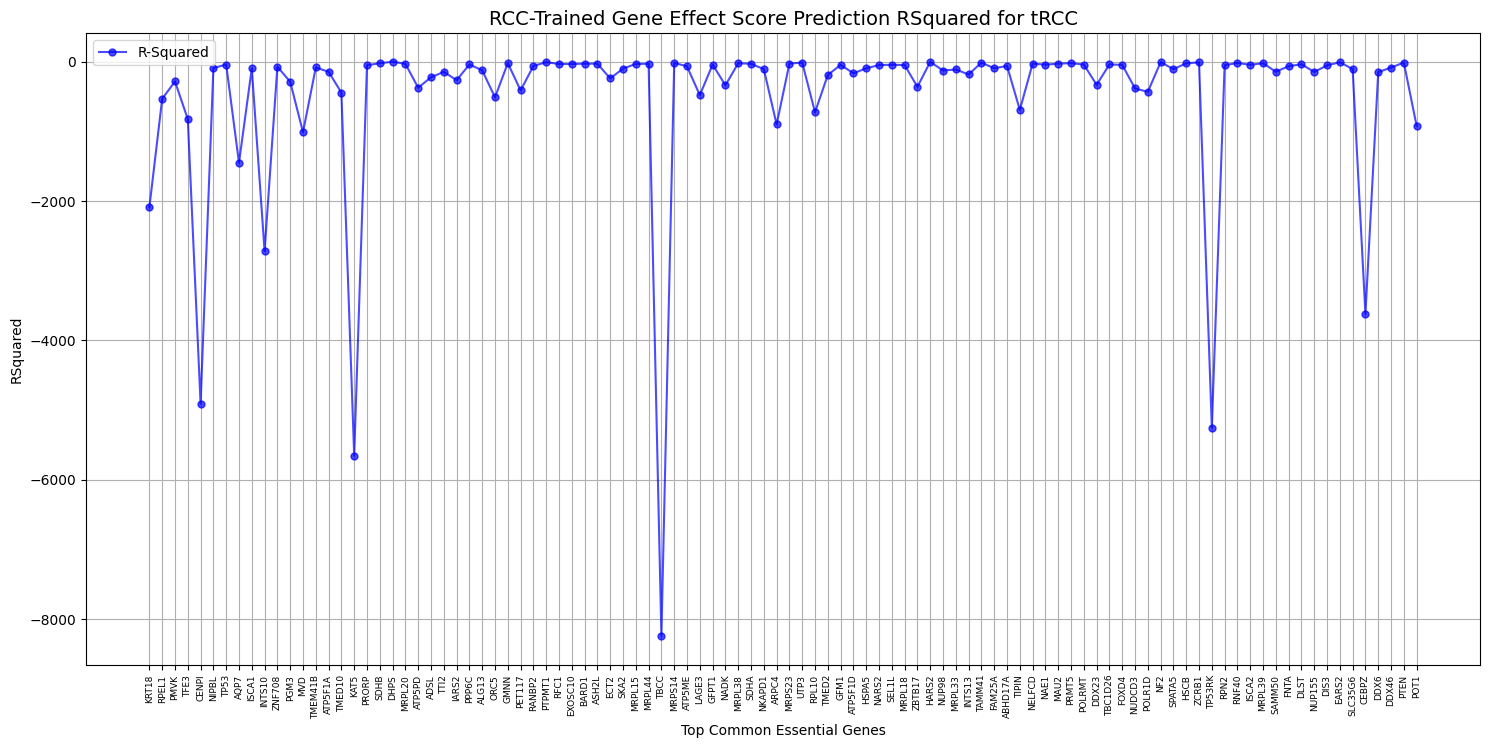

Average RSquared for predicted gene effect scores on testing subset of tRCC CCLs: -492.6


In [37]:
pred_RSquared = lf.PredGeneRSquared(tRCC_chronos_gene_effects, RCC_tRCC_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_RSquared, 
            {"RSquared": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "RSquared"], 
            main_title="RCC-Trained Gene Effect Score Prediction RSquared for tRCC",
            legend_titles={"RSquared": "tRCC CCL"})

print("Average RSquared for predicted gene effect scores on testing subset of tRCC CCLs: {0:.4}".format(pred_RSquared["R-Squared"].mean()))

### ccRCC CCLs Linear Models tRCC Gene Effect Score Predictions

In [38]:
ccRCC_tRCC_essential_gene_preds, ccRCC_tRCC_essential_gene_RMSE = lf.ComputeGenePredictions(tRCC_gene_exp, tRCC_chronos_gene_effects, ccRCC_top100_essential_gene_models)

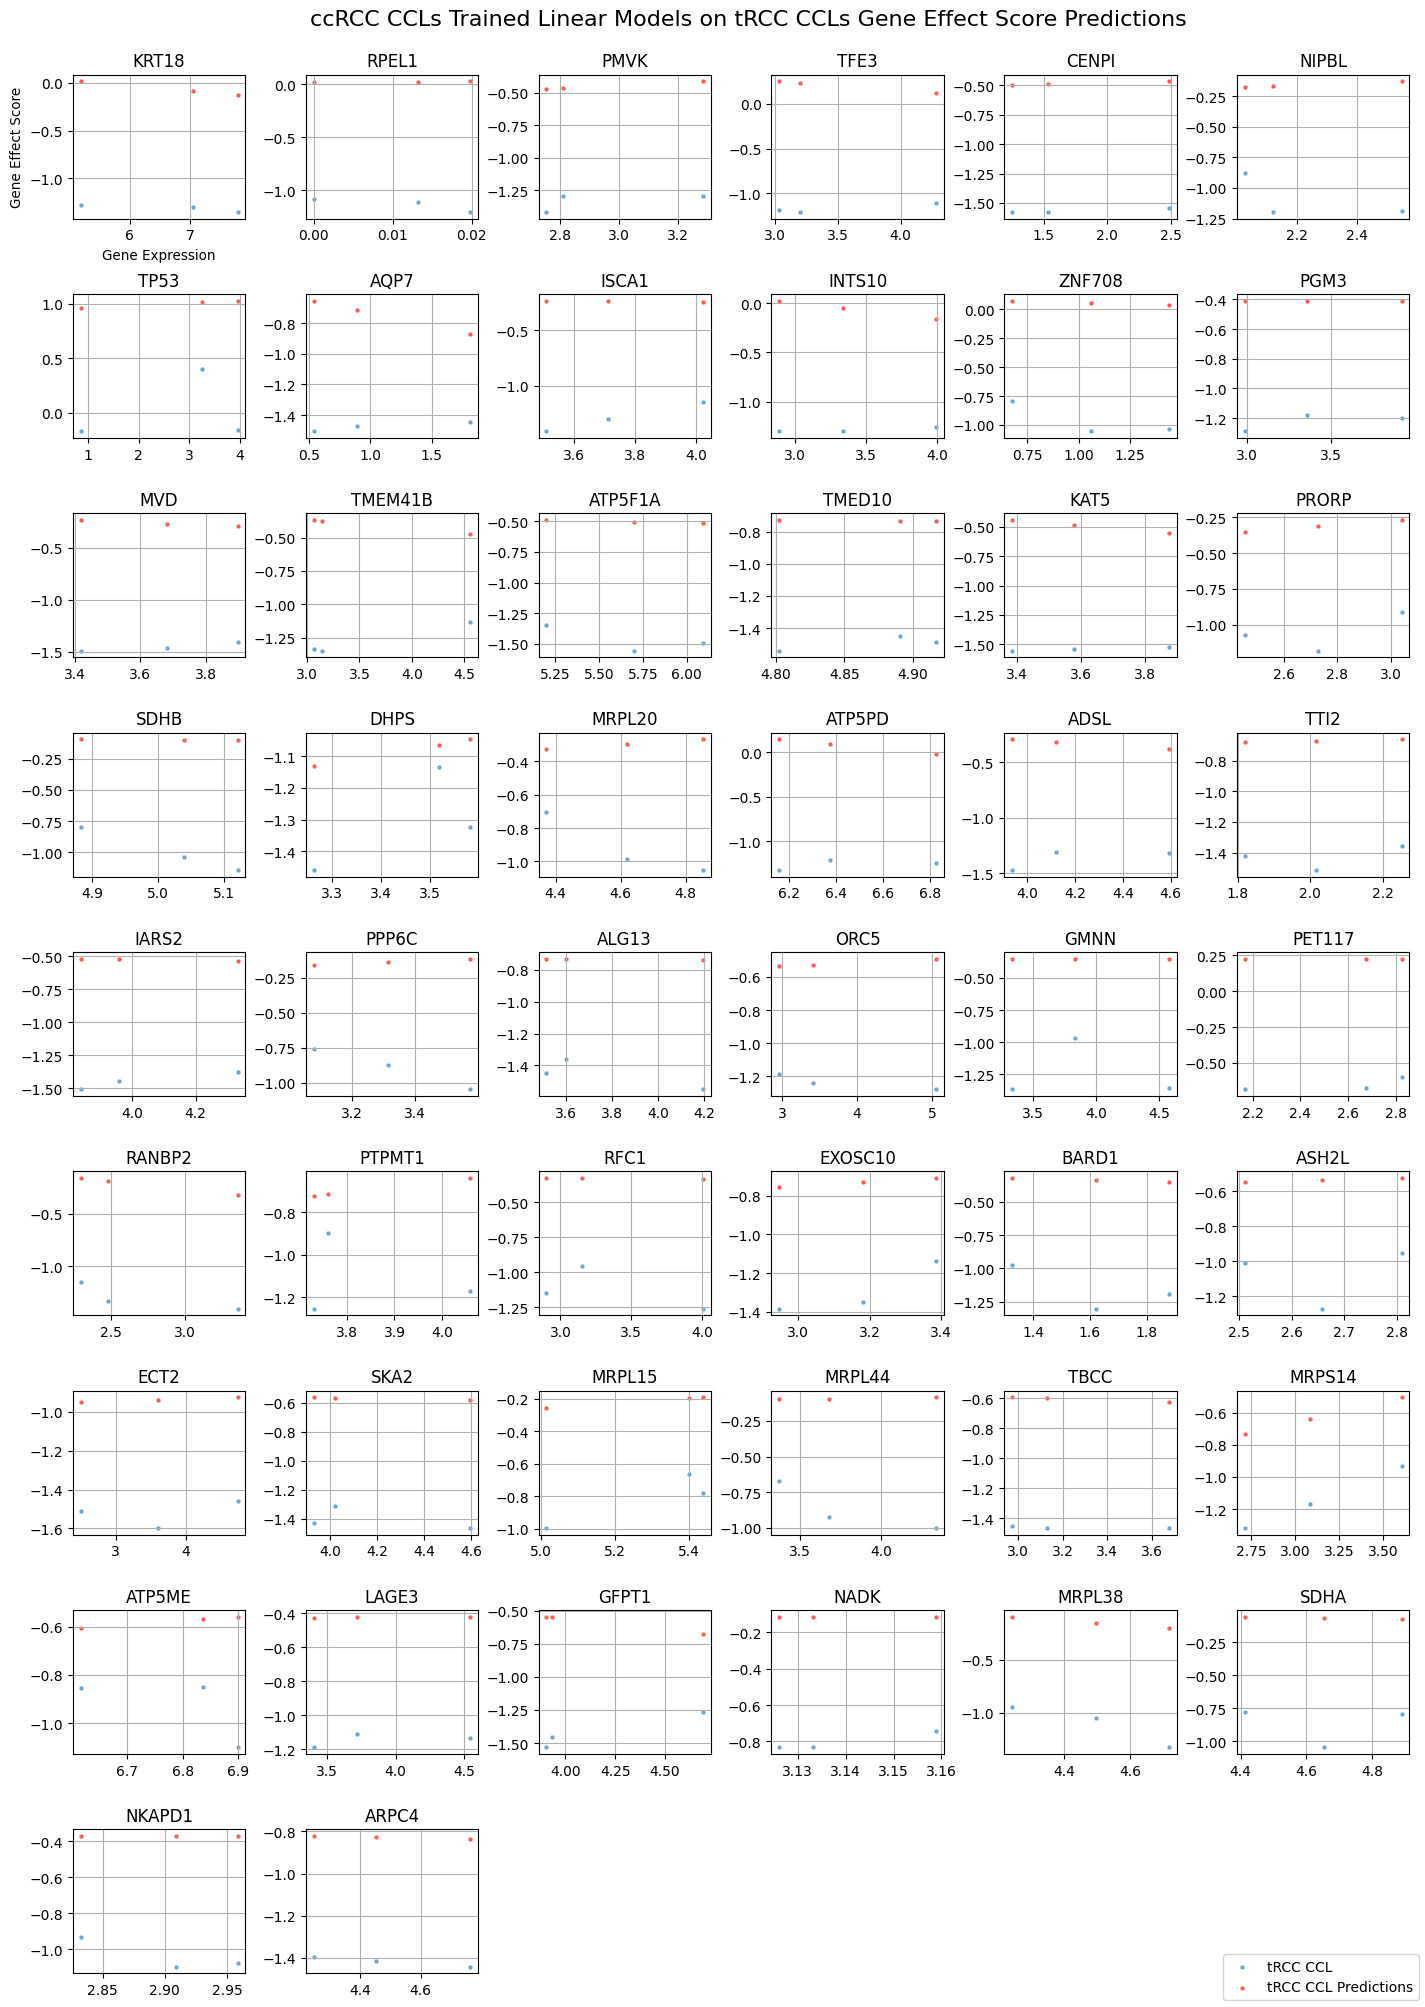

In [39]:
lf.GeneRelMiniPlot(tRCC_gene_exp, tRCC_chronos_gene_effects, top100_essential_genes[:50],
                   rel2_X=tRCC_gene_exp,
                   rel2_Y=ccRCC_tRCC_essential_gene_preds,
                   main_title="ccRCC CCLs Trained Linear Models on tRCC CCLs Gene Effect Score Predictions",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "tRCC CCL", "rel2": "tRCC CCL Predictions"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

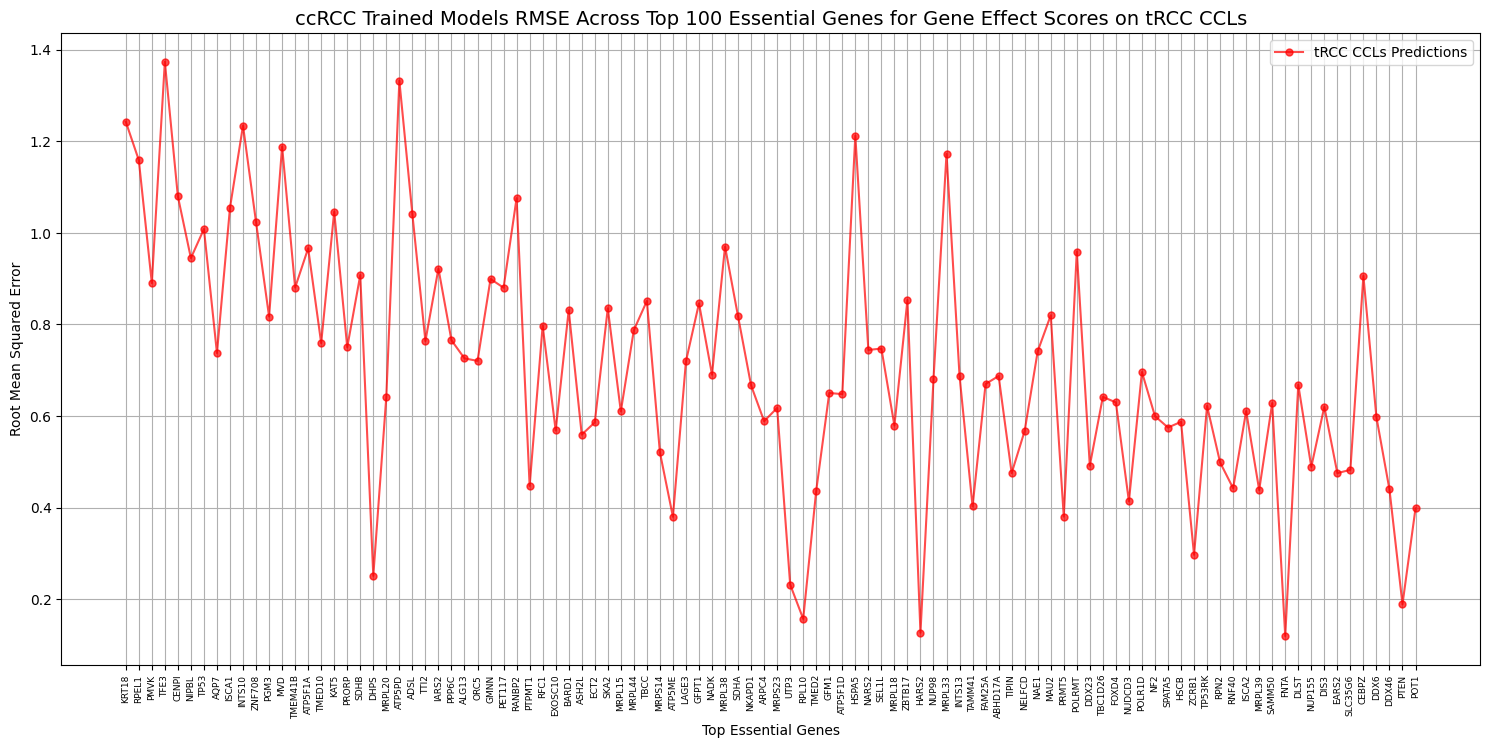

Average RMSE for predicted gene effect scores on tRCC CCLs: 0.7095


In [40]:
lf.LinePlot(ccRCC_tRCC_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="ccRCC Trained Models RMSE Across Top 100 Essential Genes for Gene Effect Scores on tRCC CCLs",
            legend_titles={"RMSE": "tRCC CCLs Predictions"})

print("Average RMSE for predicted gene effect scores on tRCC CCLs: {0:.4}".format(ccRCC_tRCC_essential_gene_RMSE["RMSE"].mean()))

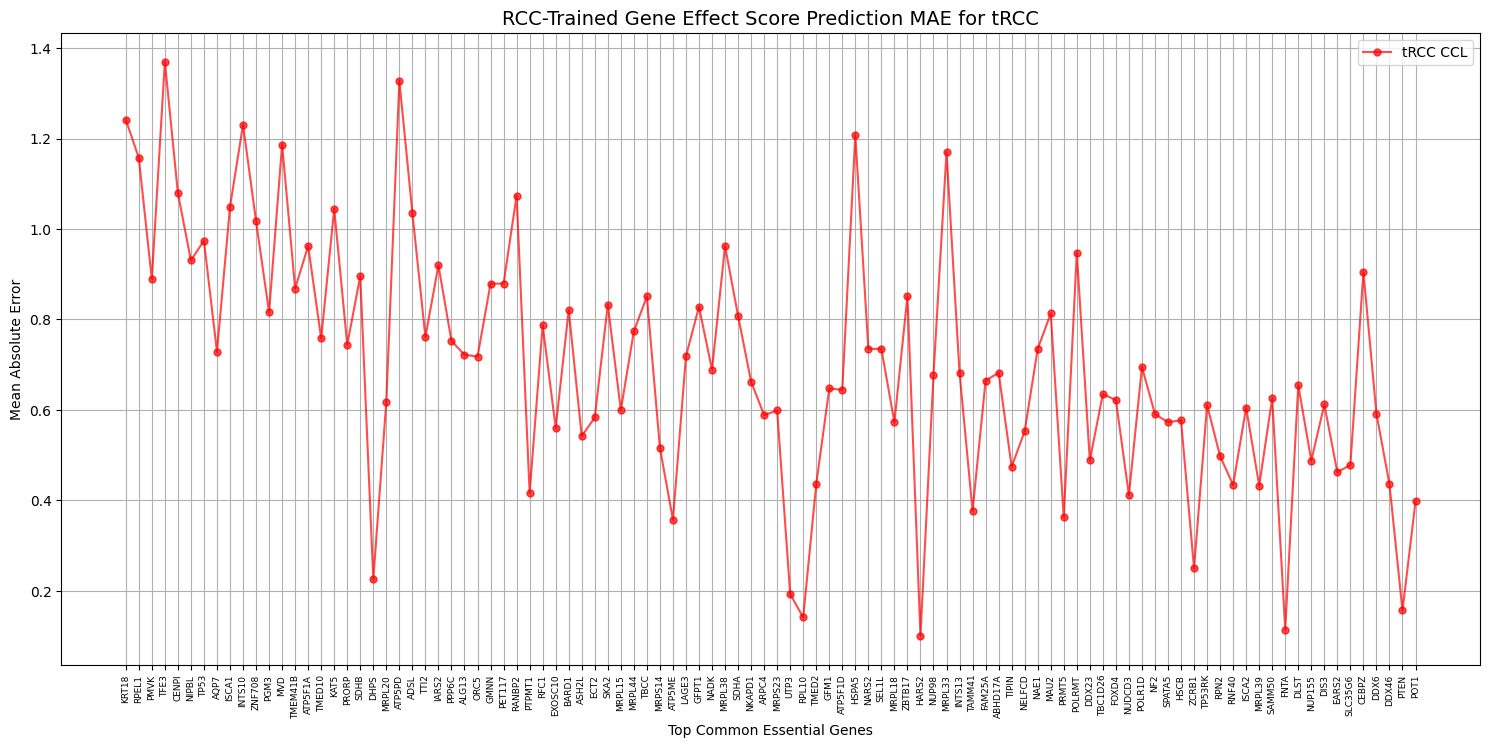

Average MAE for predicted gene effect scores on testing subset of tRCC CCLs: 0.701


In [41]:
pred_MAE = lf.PredGeneMAE(tRCC_chronos_gene_effects, ccRCC_tRCC_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_MAE, 
            {"MAE": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "Mean Absolute Error"], 
            main_title="RCC-Trained Gene Effect Score Prediction MAE for tRCC",
            legend_titles={"MAE": "tRCC CCL"})

print("Average MAE for predicted gene effect scores on testing subset of tRCC CCLs: {0:.4}".format(pred_MAE["MAE"].mean()))

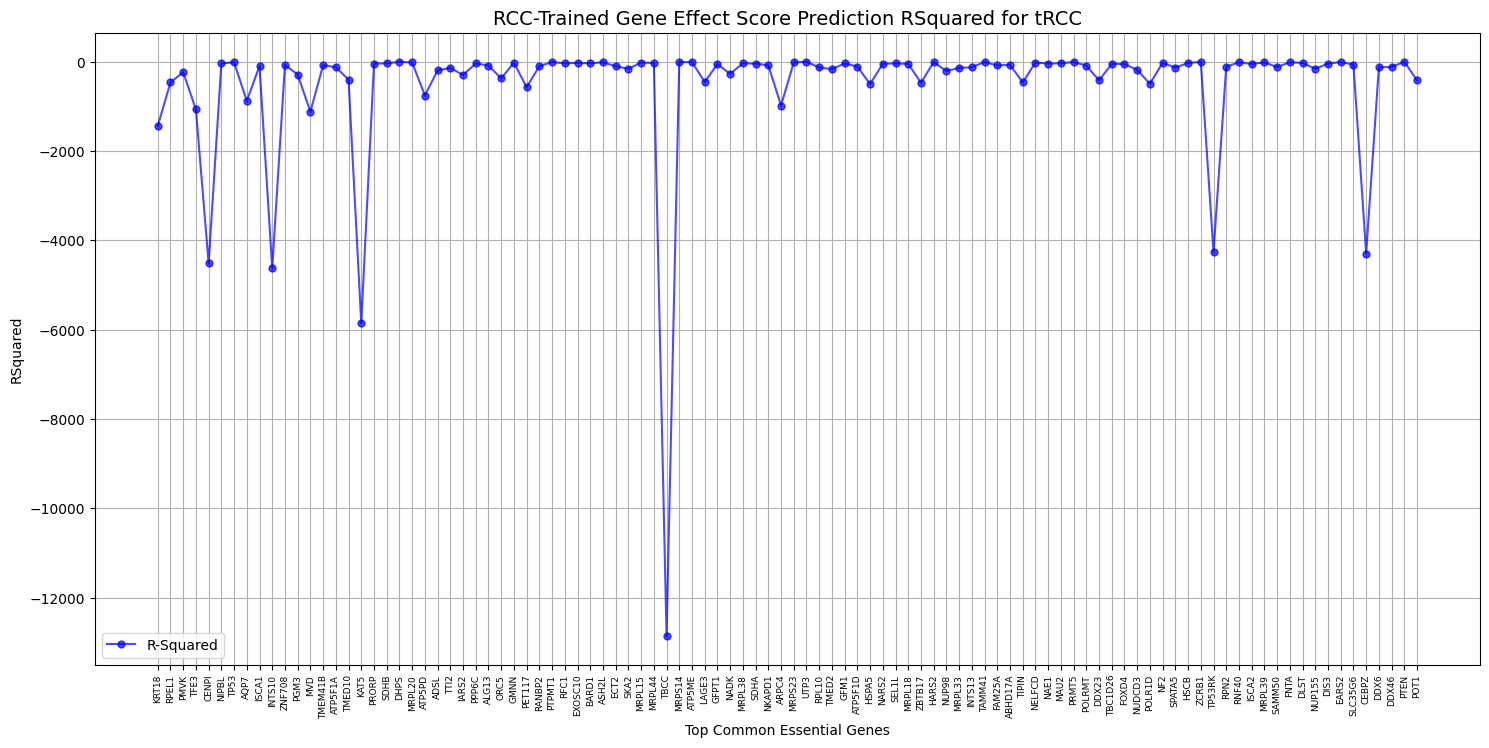

Average RSquared for predicted gene effect scores on testing subset of tRCC CCLs: -533.8


In [42]:
pred_RSquared = lf.PredGeneRSquared(tRCC_chronos_gene_effects, ccRCC_tRCC_essential_gene_preds, genes=top100_essential_genes)

lf.LinePlot(pred_RSquared, 
            {"RSquared": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "RSquared"], 
            main_title="RCC-Trained Gene Effect Score Prediction RSquared for tRCC",
            legend_titles={"RSquared": "tRCC CCL"})

print("Average RSquared for predicted gene effect scores on testing subset of tRCC CCLs: {0:.4}".format(pred_RSquared["R-Squared"].mean()))